# Memecoin active trading strategy, BNB chain validation

- Deal with this scam https://tradingstrategy.ai/trading-view/binance/pancakeswap-v2/ftc-usdt

# Set up

Set up Trading Strategy data client.


In [30]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [31]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "76-ava-variant-f"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #s
    # See list here: TODO
    #
    chain_id = ChainId.avalanche
    exchanges = {"trader-joe", "pangolin"}
    
    #
    # Basket construction and rebalance parameters
    #   
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 10  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 250  # Don't make buys less than this amount
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    # ATH indicator parameters
    ath_delay_bars = 48
    ath_window_bars = 30 * 24
    ath_threshold = 1.05
    ath_span = 4 * 24  # How many bars to use in exponential moving average for ATH filtering

    # RSI filter parameters
    daily_rsi_bars = 90
    daily_rsi_threshold = 25
    
    # For the length of trailing sharpe used in inclusion criteria
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_volatility_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    tvl_ewm_span = 7 * 24  # Smooth TVL inclusin criteria
    min_volume = 1_500   # USD
    min_tvl_prefilter = 100_000  # USD - to reduce number of trading pairs for backtest-purposes only
    min_tvl = 100_000  # USD - set to same as above if you want to avoid any survivorship bias
    min_token_sniffer_score = 20  # 20 = AAVE


    #
    # Yield on cash
    #
    use_aave = False

    #     
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2023, 1, 1)
    backtest_end = datetime.datetime(2025, 2, 4)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Chain configuration

- Configure different chain parameters
- Allows us to hop between different chains easily in the same notebook

In [32]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.lending import LendingProtocolType


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
        "cbBTC"
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v2", "WETH", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "AAVE",
        "WETH",
        "WBTC",
    ]

    VOL_PAIR = (Parameters.chain_id, "uniswap-v3", "WBTC", "USDC", 0.0030)

    #: Needed for USDC credit
    LENDING_RESERVES  = [
        (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
    ]    

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.binance:
    SUPPORTING_PAIRS = [
        (ChainId.binance, "pancakeswap-v2", "WBNB", "USDT", 0.0025),  
        (ChainId.binance, "pancakeswap-v2", "ETH", "WBNB", 0.0025),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WBNB",
        "FTC",
        "TRUNK",
        "CUMMIES",
    ]

    VOL_PAIR = (Parameters.chain_id, "pancakeswap-v2", "WBNB", "USDT", 0.0025)

    LENDING_RESERVES = None

    PREFERRED_STABLECOIN = USDT_NATIVE_TOKEN[Parameters.chain_id.value].lower()

elif Parameters.chain_id == ChainId.avalanche:
    SUPPORTING_PAIRS = [
        (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030),  
        (ChainId.avalanche, "trader-joe", "WETH.e", "WAVAX", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "WAVAX",
        "JOE",
        "WETH.e",
    ]

    VOL_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030)

    PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

    LENDING_RESERVES = None    

else:
    raise NotImplementedError(f"Chain not supported: {parameters.chain_id}")

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [33]:
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client
from tradingstrategy.utils.token_extra_data import filter_scams
from tradingstrategy.utils.liquidity_filter import prefilter_pairs_with_tvl

from tradingstrategy.utils.token_filter import filter_for_trading_fee
from tradingstrategy.utils.token_filter import filter_for_quote_tokens
from tradingstrategy.utils.token_filter  import filter_for_stablecoins
from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import StablecoinFilteringMode
from tradingstrategy.utils.token_filter import filter_for_derivatives


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe



def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    category_df = pairs_df
    category_df = add_base_quote_address_columns(category_df)
    category_df = filter_for_stablecoins(category_df, StablecoinFilteringMode.only_volatile_pairs)
    category_df = filter_for_derivatives(category_df)

    allowed_quotes = {
        PREFERRED_STABLECOIN,
        WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }

    category_df = filter_for_quote_tokens(category_df, allowed_quotes)
    category_pair_ids = category_df["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Get TVL data for prefilteirng
    pairs_df = prefilter_pairs_with_tvl(
        client,
        pairs_df,
        chain_id=Parameters.chain_id,
        min_tvl=Parameters.min_tvl_prefilter,
        start=Parameters.backtest_start,
        end=Parameters.backtest_end,
    )

    print(f"After TVL filter {Parameters.min_tvl_prefilter:,} USD we have {len(pairs_df)} tradeable pairs")

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Scam filter using TokenSniffer
    logging.getLogger().setLevel(logging.INFO)
    pairs_df = filter_scams(
        pairs_df, 
        client, 
        min_token_sniffer_score=Parameters.min_token_sniffer_score,
        min_volume_24h_usd=0,
        verbose=False,
        )
    pairs_df = pairs_df.sort_values("volume", ascending=False)
    logging.getLogger().setLevel(logging.WARNING)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
        lending_reserves=LENDING_RESERVES,
    )

    reserve_asset = PREFERRED_STABLECOIN

    print("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = False

    print(f"Total {strategy_universe.get_pair_count()}")

    return strategy_universe

    
strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

print("Universe creation done")

display_strategy_universe(
    strategy_universe, 
    sort_key="base",
    sort_numeric=False,
)


After TVL filter 100,000 USD we have 277 tradeable pairs
2025-02-07 18:07:30,522 tradingstrategy.utils.token_extra_data             INFO     Loading extra metadata for 240 tokens
2025-02-07 18:07:30,524 tradingstrategy.utils.token_extra_data             INFO     Total queried tokens will be 237
2025-02-07 18:07:30,525 tradingstrategy.transport.cache                    INFO     /top call with params {'addresses': '0x2f6f07cdcf3588944bf4c42ac74ff24bf56e7590,0x420fca0121dc28039145009570975747295f2329,0x2d0afed89a6d6a100273db377dba7a32c739e314,0x60781c2586d68229fde47564546784ab3faca982,0x62edc0692bd897d2295872a9ffcac5425011c661,0x62d0a8458ed7719fdaf978fe5929c6d342b0bfce,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5,0xb8d7710f7d8349a506b75dd184f05777c82dad0c,0x63a72806098bd3d9520cc43356dd78afe5d386d9,0x50b7545627a5162f82a992c33b87adc75187b218,0x5947bb275c521040051d82396192181b413227a3,0xca8ebfb8e1460aaac7c272

Loading OHLCV data for 97 pairs:   0%|          | 0/66096000 [00:00<?, ?it/s]

Loading TVL/liquidity data for 97 pairs:   0%|          | 0/97 [00:00<?, ?it/s]

Creating trading universe
Total 97
Universe creation done


base   quote    exchange  fee %   type:        price  \
id                                                                  
3582307       $Td   WAVAX  trader-joe    0.3  traded         0.00   
2594199    AAVE.e   WAVAX  trader-joe    0.3  traded       277.54   
3459064      ABOB   WAVAX  trader-joe    0.3  traded         0.00   
2600715   ALPHA.e   WAVAX  trader-joe    0.3  traded         0.06   
4603933     ARENA   WAVAX  trader-joe    0.3  traded         0.01   
3471286     ATECH   WAVAX  trader-joe    0.3  traded         0.00   
2878506       BAY    USDC  trader-joe    0.3  traded         0.00   
3457135      BEAM    USDC  trader-joe    0.3  traded         0.01   
3446131      BEAR   WAVAX  trader-joe    0.3  traded         0.00   
5056787       BGR   WAVAX  trader-joe    0.3  traded         0.02   
4780022       BIG   WAVAX  trader-joe    0.3  traded         0.01   
3482387     BINGO   WAVAX  trader-joe    0.3  traded         0.00   
5078296       BRO   WAVAX  trader-joe    0.3  traded  <not avail>   
2610819       BSN   WAVAX  trader-joe    0.3  traded         0.13   
2614528     BTC.b   WAVAX  trader-joe    0.3  traded    101577.44   
2767291      BUSD   WAVAX    pangolin    0.3  traded         0.96   
2684518       CAI   WAVAX  trader-joe    0.3  traded       118.75   
2613457       CCY   WAVAX  trader-joe    0.3  traded         0.00   
2599022       CLY   WAVAX  trader-joe    0.3  traded         0.12   
3444388       COQ   WAVAX  trader-joe    0.3  traded         0.00   
3645703       CPP   WAVAX  trader-joe    0.3  traded         0.29   
2614986      DCAR    USDC  trader-joe    0.3  traded         0.00   
2910852      DCAU    USDC  trader-joe    0.3  traded         0.80   
2681001      DGNX   WAVAX    pangolin    0.3  traded         0.03   
2606657      DOMI   WAVAX  trader-joe    0.3  traded         0.01   
3482420       DWC   WAVAX  trader-joe    0.3  traded         0.00   
2610341       ECD   WAVAX  trader-joe    0.3  traded         0.00   
2602263       EGG   WAVAX  trader-joe    0.3  traded         0.00   
2592230       ETH   WAVAX    pangolin    0.3  traded      5395.08   
2602306      FEED   WAVAX  trader-joe    0.3  traded         0.00   
2603476      FIRE   WAVAX  trader-joe    0.3  traded         0.37   
3137902       FLD   WAVAX  trader-joe    0.3  traded         0.00   
3518740       GAU    USDC  trader-joe    0.3  traded         0.01   
3465190       GEC   WAVAX  trader-joe    0.3  traded         0.00   
3037803       GGP   WAVAX  trader-joe    0.3  traded         7.70   
2606219       GMX   WAVAX  trader-joe    0.3  traded        18.86   
2607857       HON   WAVAX  trader-joe    0.3  traded         0.01   
3663828   HUNDRED    USDC  trader-joe    0.3  traded         0.00   
2592716     HUSKY   WAVAX    pangolin    0.3  traded         0.00   
2605905       HeC   WAVAX  trader-joe    0.3  traded         0.00   
2602790       IME   WAVAX  trader-joe    0.3  traded         0.00   
2593184       JOE   WAVAX  trader-joe    0.3  traded         0.24   
3561094     JUICE   WAVAX  trader-joe    0.3  traded         0.00   
3702268    JUNIOR   WAVAX  trader-joe    0.3  traded         0.00   
3461293     KIMBO   WAVAX  trader-joe    0.3  traded         0.00   
3547059  KINGSHIT   WAVAX  trader-joe    0.3  traded        44.71   
3583497      KONG   WAVAX  trader-joe    0.3  traded         0.00   
3570546     KOVIN   WAVAX  trader-joe    0.3  traded         0.00   
3589575      LAMA   WAVAX  trader-joe    0.3  traded         0.00   
2593361    LINK.e   WAVAX  trader-joe    0.3  traded        21.75   
2600491       LVT   WAVAX  trader-joe    0.3  traded         0.00   
2614637     MAGIC    USDC  trader-joe    0.3  traded         0.00   
3447800      MEAT   WAVAX  trader-joe    0.3  traded         0.00   
3576971      MEOW   WAVAX  trader-joe    0.3  traded         0.00   
2593873       MIM   WAVAX  trader-joe    0.3  traded         1.00   
5020499      MYST    USDC  trader-joe    0.3  traded         0.03   
3461832   N

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [34]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 97 assets
Category trading pairs 97
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [35]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


@indicators.define()
def ath(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
) -> pd.Series:
    """All time high indicator.

    - Calculate % we are above all time high

    :param ath_window_bars:
        We look history for this many bars to find ATH

    :param ath_delay_bars: 
        We skip the this most recent entries for ATH.

        E.g. ATH in a previous bar is ignored.
    
    :return:
        %  we are above lagged all time high.

        Value 1.1 means we are 10% above of the previous ATH.
    """
    shifted = close.shift(ath_delay_bars)
    windowed = shifted.rolling(
        window=ath_window_bars, 
        min_periods=ath_window_bars,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def volatility(close: pd.Series, rolling_volatility_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rolling_volatility_bars).std()
    return rolling_std


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series



@indicators.define(dependencies=(volatility,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rolling_volatility_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rolling_volatility_bars": rolling_volatility_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility



@indicators.define(source=IndicatorSource.ohlcv)
def daily_price(open, high, low, close) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))
    return daily_df


@indicators.define(source=IndicatorSource.dependencies_only_per_pair, dependencies=[daily_price])
def daily_rsi(
    daily_rsi_bars,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
):
    daily_close = dependency_resolver.get_indicator_data(
        "daily_price",
        pair=pair,
        column="close",
    )
    rsi_series = pandas_ta.rsi(
        daily_close,
        length=daily_rsi_bars,
    )

    if rsi_series is None:        
        return empty_series
    
    return rsi_series



@indicators.define(dependencies=[ath, ath, daily_rsi])
def signal(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,
    daily_rsi_bars: int,
    daily_rsi_threshold: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Combine ATH signal with daily RSI filter.
    
    - We use daily RSI filter to get rid of crap pairs like FTC
    """

    rsi = dependency_resolver.get_indicator_data(
        "daily_rsi",
        parameters={"daily_rsi_bars": daily_rsi_bars},
        pair=pair,
    )

    # Set default RSI value so we include pairs
    # without enough history
    rsi = rsi.fillna(50).infer_objects(copy=False)

    ath = dependency_resolver.get_indicator_data(
        "ath",
        parameters={
            "ath_delay_bars": ath_delay_bars,
            "ath_window_bars": ath_window_bars,
        },
        pair=pair,
    )
    ath_core = ath.ewm(span=ath_span).mean() - ath_threshold

    # Use daily RSI as a thrash filter
    # See FTC: https://tradingstrategy.ai/trading-view/binance/pancakeswap-v2/ftc-usdt
    df = pd.DataFrame({
        "rsi": rsi,
        "ath_core": ath_core,
    })
    df["rsi"] = df["rsi"].ffill().infer_objects(copy=False)  # forward-fill from daily to hourly
    mask = df.rsi >= daily_rsi_threshold

    df['ath_thresholded'] = 0.0  # Initialize with zeros
    df.loc[mask, 'ath_thresholded'] = df.loc[mask, 'ath_core']  # Copy ATH indicator values from non-masked timestamps
    return df["ath_thresholded"]



@indicators.define(dependencies=(signal,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,    
    daily_rsi_bars: int,
    daily_rsi_threshold: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate our "signal" across all pairs.

    - Use median - mean is skewed by outliers

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        "signal",
        parameters={
            "ath_window_bars": ath_window_bars,
            "ath_delay_bars": ath_delay_bars,
            "ath_threshold": ath_threshold,
            "ath_span": ath_span,
            "daily_rsi_bars": daily_rsi_bars,
            "daily_rsi_threshold": daily_rsi_threshold,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).median()
    
    return cleaned_avg_signal


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 19 indicators:
Using indicator cache /Users/moo/.cache/indicators/avalanche_1h_97_2023-01-02-2025-02-04_ff


/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_85167/3292413256.py:479: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_85167/3292413256.py:479: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_85167/3292413256.py:479: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.s

# Available pairs

- Number of pairs available to trade every month



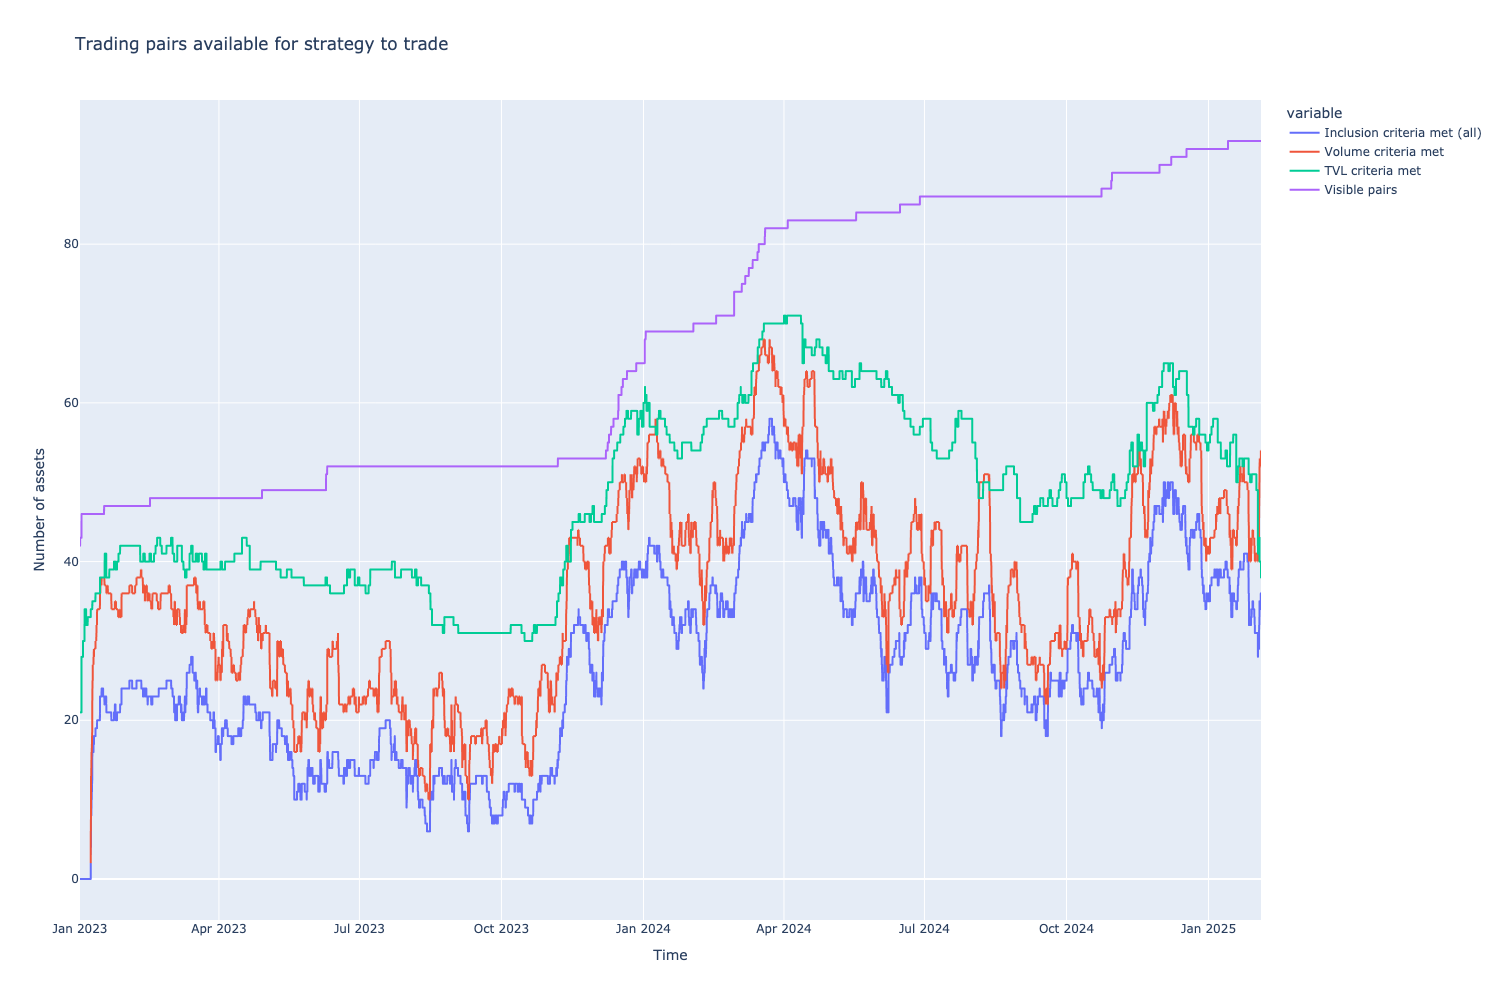

Inclusion criteria met (all)  Volume criteria met  \
2025-02-03 20:00:00                            35                 52.0   
2025-02-03 21:00:00                            36                 53.0   
2025-02-03 22:00:00                            36                 54.0   
2025-02-03 23:00:00                            36                 54.0   
2025-02-04 00:00:00                            34                 54.0   

                     TVL criteria met  Visible pairs  
2025-02-03 20:00:00                40             93  
2025-02-03 21:00:00                40             93  
2025-02-03 22:00:00                40             93  
2025-02-03 23:00:00                40             93  
2025-02-04 00:00:00                38             93

In [36]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for strategy to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [37]:
from tradingstrategy.liquidity import LiquidityDataUnavailable

series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

def _get_ticker(pair_id):
    try:
        return strategy_universe.get_pair_by_id(pair_id).get_ticker()
    except Exception:
        return "<pair metadata missing>"
    
def _get_dex(pair_id):
    try:
        return strategy_universe.get_pair_by_id(pair_id).exchange_name
    except Exception:
        return "<DEX metadata missing>"

df["Ticker"] = first_appearance_series.index.map(_get_ticker)
df["DEX"] = first_appearance_series.index.map(_get_dex)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    try:
        tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
            pair_id,
            timestamp,
            tolerance=pd.Timedelta(days=2),
        )
        return tvl
    except LiquidityDataUnavailable:
        # TODO Data dates mismatch?
        return 0 

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 82 trading pairs, when they meet all inclusion criteria:


Included at          Ticker         DEX  TVL at inclusion  \
2767291 2023-01-08 00:00:00      BUSD-WAVAX    pangolin        142,086.97   
2598959 2023-01-08 00:00:00      THOR-WAVAX  trader-joe        788,878.90   
2611812 2023-01-08 00:00:00        STG-USDC  trader-joe      1,319,679.34   
2592242 2023-01-08 01:00:00       PNG-WAVAX    pangolin      1,324,713.07   
2593184 2023-01-08 03:00:00       JOE-WAVAX  trader-joe      4,017,859.41   
2614528 2023-01-08 03:00:00     BTC.b-WAVAX  trader-joe      1,684,750.68   
2593360 2023-01-08 03:00:00    WBTC.e-WAVAX  trader-joe        441,894.34   
2593873 2023-01-08 03:00:00       MIM-WAVAX  trader-joe        763,799.27   
2592725 2023-01-08 10:00:00      XAVA-WAVAX    pangolin        676,962.40   
2610587 2023-01-08 10:00:00       VTX-WAVAX  trader-joe        468,006.14   
2602641 2023-01-08 16:00:00      VPND-WAVAX  trader-joe        927,690.21   
2613753 2023-01-08 18:00:00     STEAK-WAVAX  trader-joe        205,097.30   
2594199 2023-01-08 22:00:00    AAVE.e-WAVAX  trader-joe        247,925.33   
2593361 2023-01-08 23:00:00    LINK.e-WAVAX  trader-joe        112,458.38   
2607857 2023-01-08 23:00:00       HON-WAVAX  trader-joe        100,777.12   
2606219 2023-01-09 00:00:00       GMX-WAVAX  trader-joe      2,242,839.78   
2613641 2023-01-09 19:00:00     rloop-WAVAX  trader-joe        117,867.11   
2606757 2023-01-09 23:00:00     sAVAX-WAVAX  trader-joe      3,139,368.24   
2592230 2023-01-11 02:00:00       ETH-WAVAX    pangolin        143,435.29   
2613057 2023-01-12 02:00:00      YETI-WAVAX  trader-joe        174,818.31   
2602263 2023-01-13 22:00:00       EGG-WAVAX  trader-joe      1,966,902.11   
2684518 2023-01-14 00:00:00       CAI-WAVAX  trader-joe        575,753.18   
2599022 2023-01-14 00:00:00       CLY-WAVAX  trader-joe        102,011.90   
2596162 2023-01-15 00:00:00     SMRTr-WAVAX  trader-joe        208,050.38   
2596335 2023-01-23 14:00:00    PENDLE-WAVAX  trader-joe        313,513.35   
2605905 2023-01-27 00:00:00       HeC-WAVAX  trader-joe        180,347.51   
2614986 2023-02-02 00:00:00       DCAR-USDC  trader-joe        620,953.17   
2910852 2023-02-16 13:00:00       DCAU-USDC  trader-joe        241,331.45   
2613457 2023-02-26 00:00:00       CCY-WAVAX  trader-joe        101,373.44   
2600715 2023-03-11 04:00:00   ALPHA.e-WAVAX  trader-joe              0.00   
3037803 2023-05-05 21:00:00       GGP-WAVAX  trader-joe        513,044.19   
3137902 2023-07-08 00:00:00       FLD-WAVAX  trader-joe        102,017.17   
3134687 2023-07-08 00:00:00     w3ULL-WAVAX  trader-joe        103,469.68   
2614637 2023-11-07 00:00:00      MAGIC-USDC  trader-joe        109,833.10   
2606657 2023-11-10 00:00:00      DOMI-WAVAX  trader-joe        113,362.90   
2592716 2023-11-12 11:00:00     HUSKY-WAVAX    pangolin        110,115.78   
2681001 2023-11-13 12:00:00      DGNX-WAVAX    pangolin        171,385.16   
3446131 2023-12-08 20:00:00      BEAR-WAVAX  trader-joe        170,612.89   
3447800 2023-12-11 14:00:00      MEAT-WAVAX  trader-joe        259,702.84   
2596180 2023-12-12 00:00:00   TRACTOR-WAVAX  trader-joe        127,887.41   
3444388 2023-12-14 15:00:00       COQ-WAVAX  trader-joe      1,133,886.52   
2603476 2023-12-15 16:00:00      FIRE-WAVAX  trader-joe              0.00   
3059580 2023-12-16 15:00:00     RPEPE-WAVAX  trader-joe        139,887.05   
3450376 2023-12-18 00:00:00      WOLF-WAVAX  trader-joe        318,506.87   
3455699 2023-12-22 13:00:00       RST-WAVAX  trader-joe        203,201.41   
2601259 2023-12-22 18:00:00       PTP-WAVAX  trader-joe        647,924.14   
3461293 2023-12-24 18:00:00     KIMBO-WAVAX  trader-joe        344,652.96   
3457135 2023-12-26 00:00:00       BEAM-USDC  trader-joe        180,216.88   
3465190 2023-12-28 06:00:00       GEC-WAVAX  trader-joe        418,087.63   
3482612 2024-01-02 11:00:00      NULL-WAVAX  trader-joe        901,109.01   
2613677 2024-01-09 10:00:00     SLIME-WAVAX  trader-joe        198,492.37   
3469384 2024

# Signal across pairs

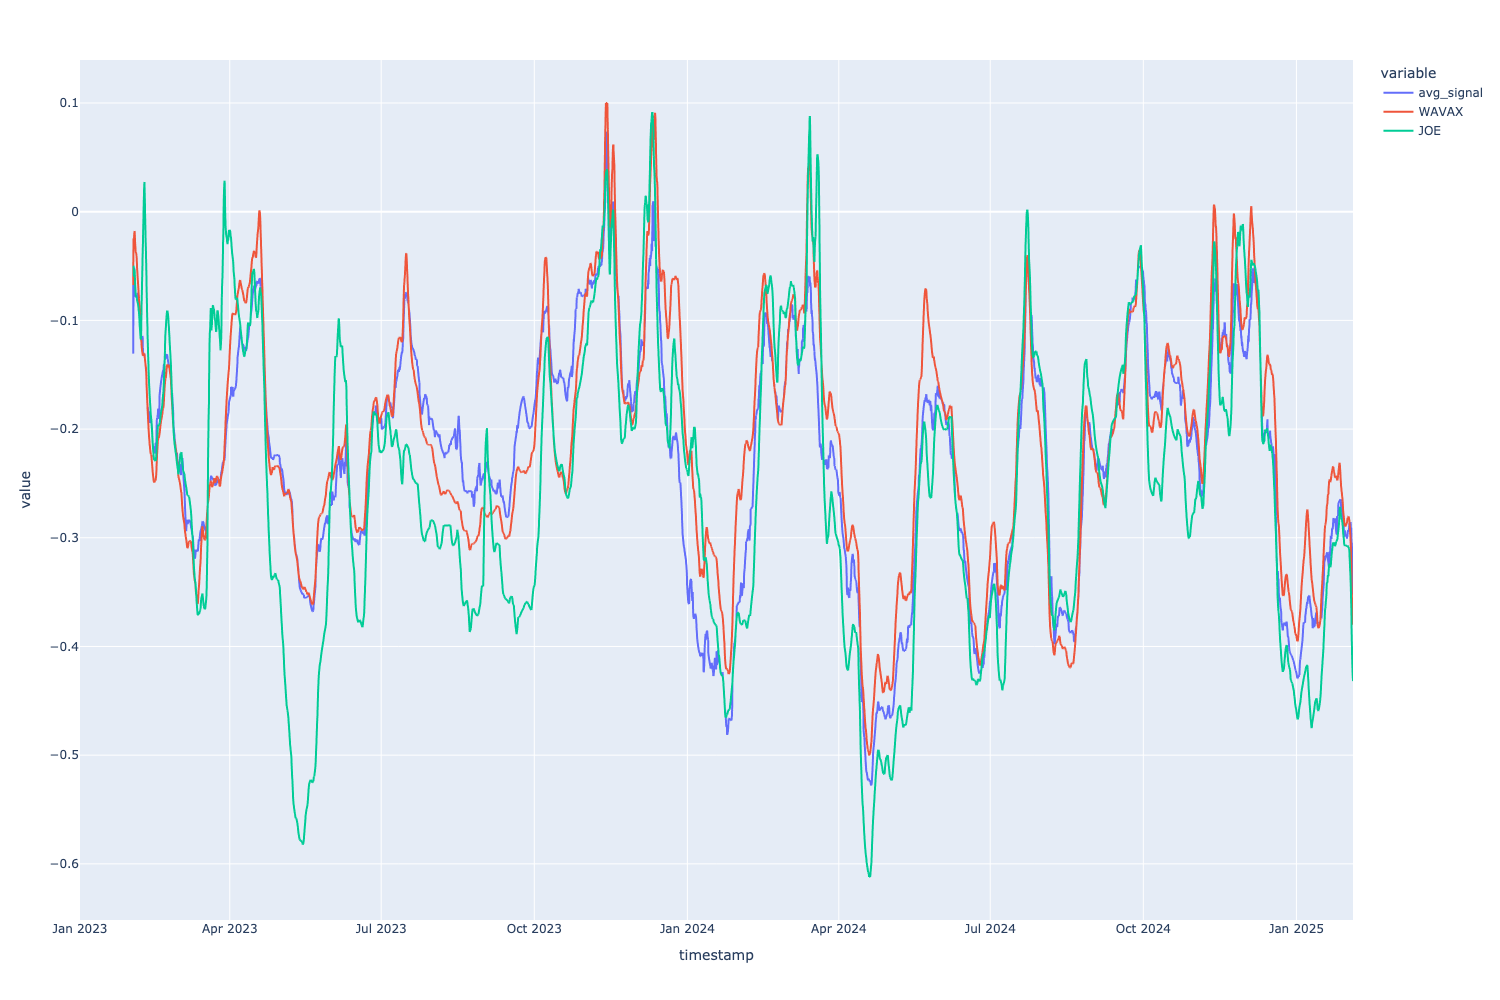

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# max_displayed_vol = avg_signal.max() * 1.1
upper_displayed = 0.1

avg_signal = indicator_data.get_indicator_series("avg_signal")

data = {
    "avg_signal": avg_signal.clip(upper=upper_displayed),
}


# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    signal = indicator_data.get_indicator_series("signal", pair=pair)
    signal = signal.clip(upper=upper_displayed)
    data[symbol] = signal
    
df = pd.DataFrame(data)
fig = px.line(df)
fig.show()


# Volatility across pairs

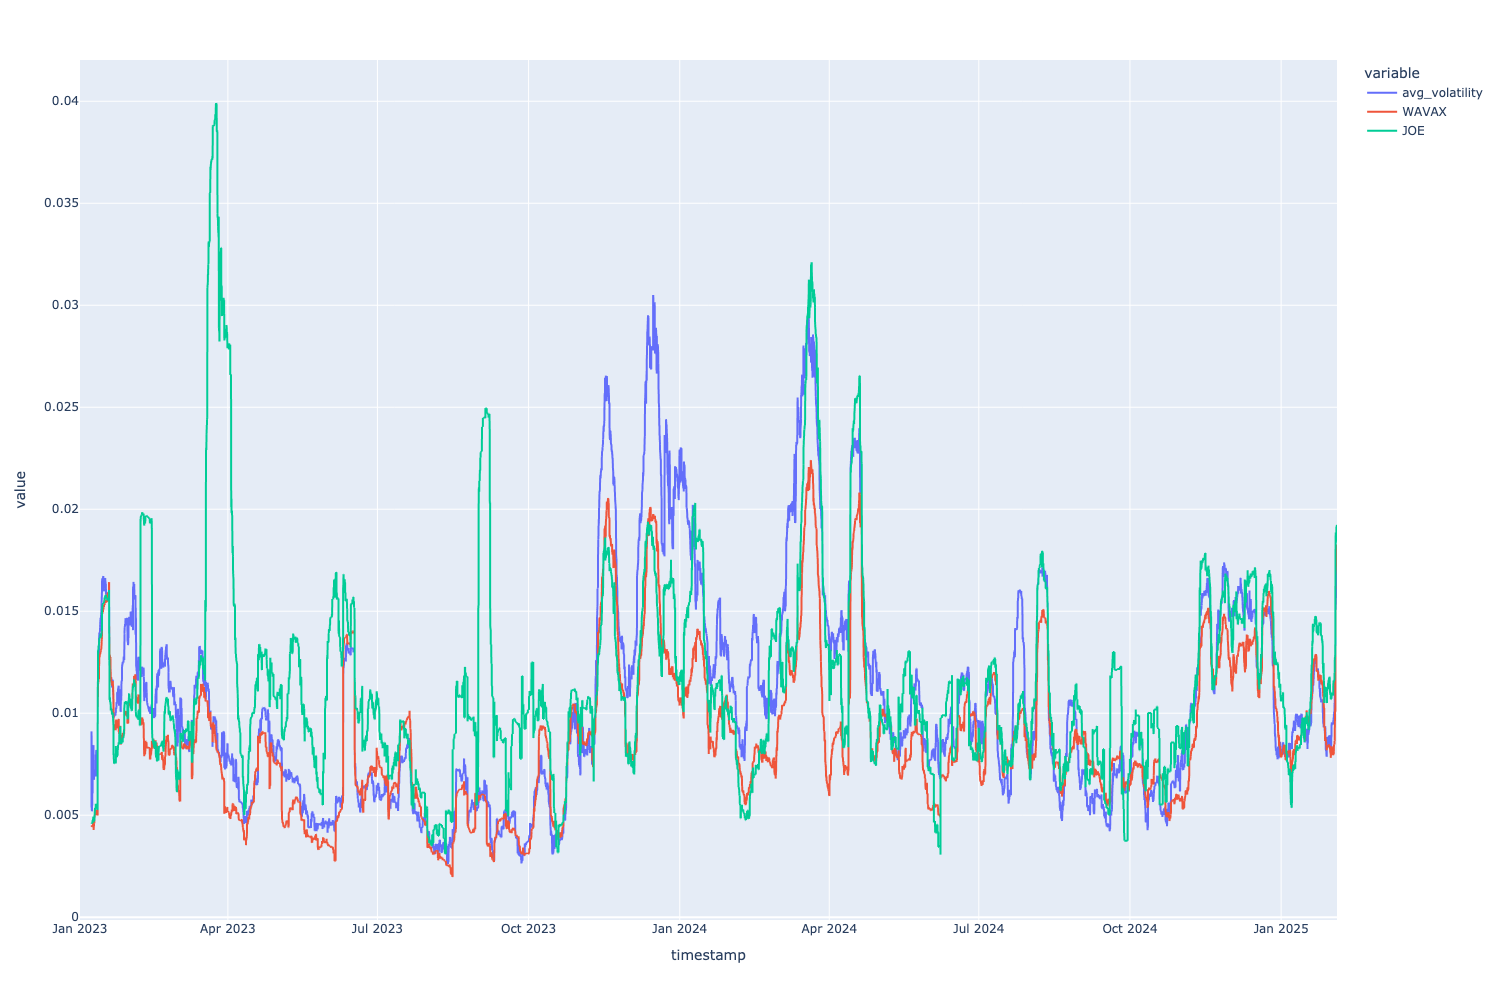

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

avg_volatility = indicator_data.get_indicator_series("avg_volatility")

volatilities = {
    "avg_volatility": avg_volatility,
}

max_displayed_vol = avg_volatility.max() * 3

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)
    volatility = volatility.clip(upper=max_displayed_vol)
    volatilities[symbol] = volatility
    
volatility_df = pd.DataFrame(volatilities)
fig = px.line(volatility_df)
fig.show()


# Price vs. signal

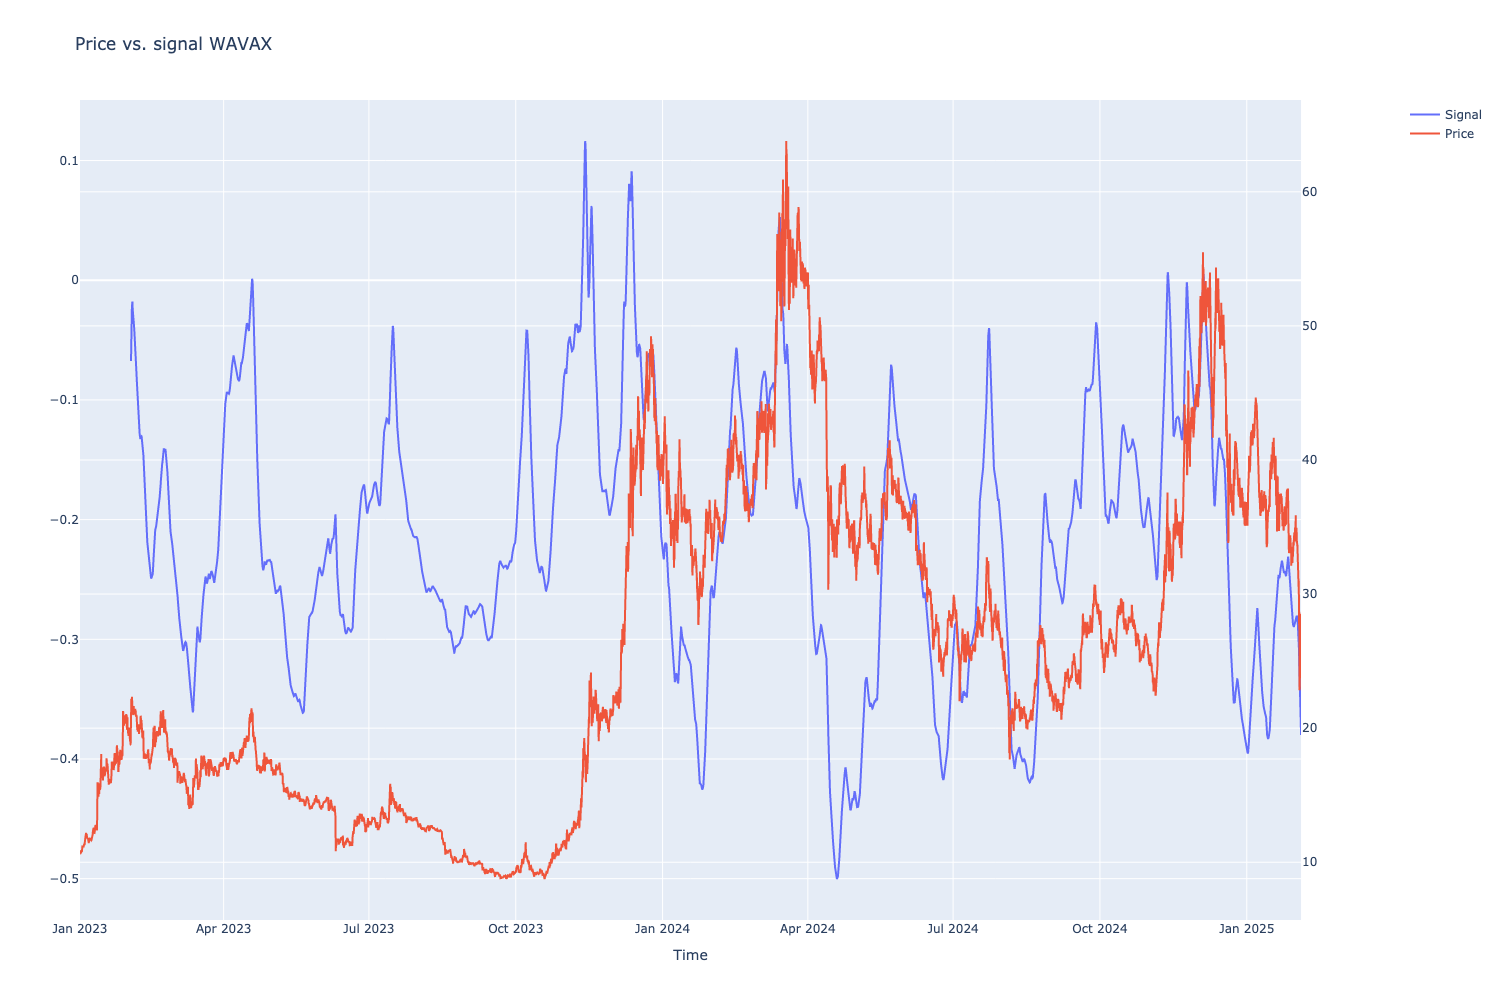

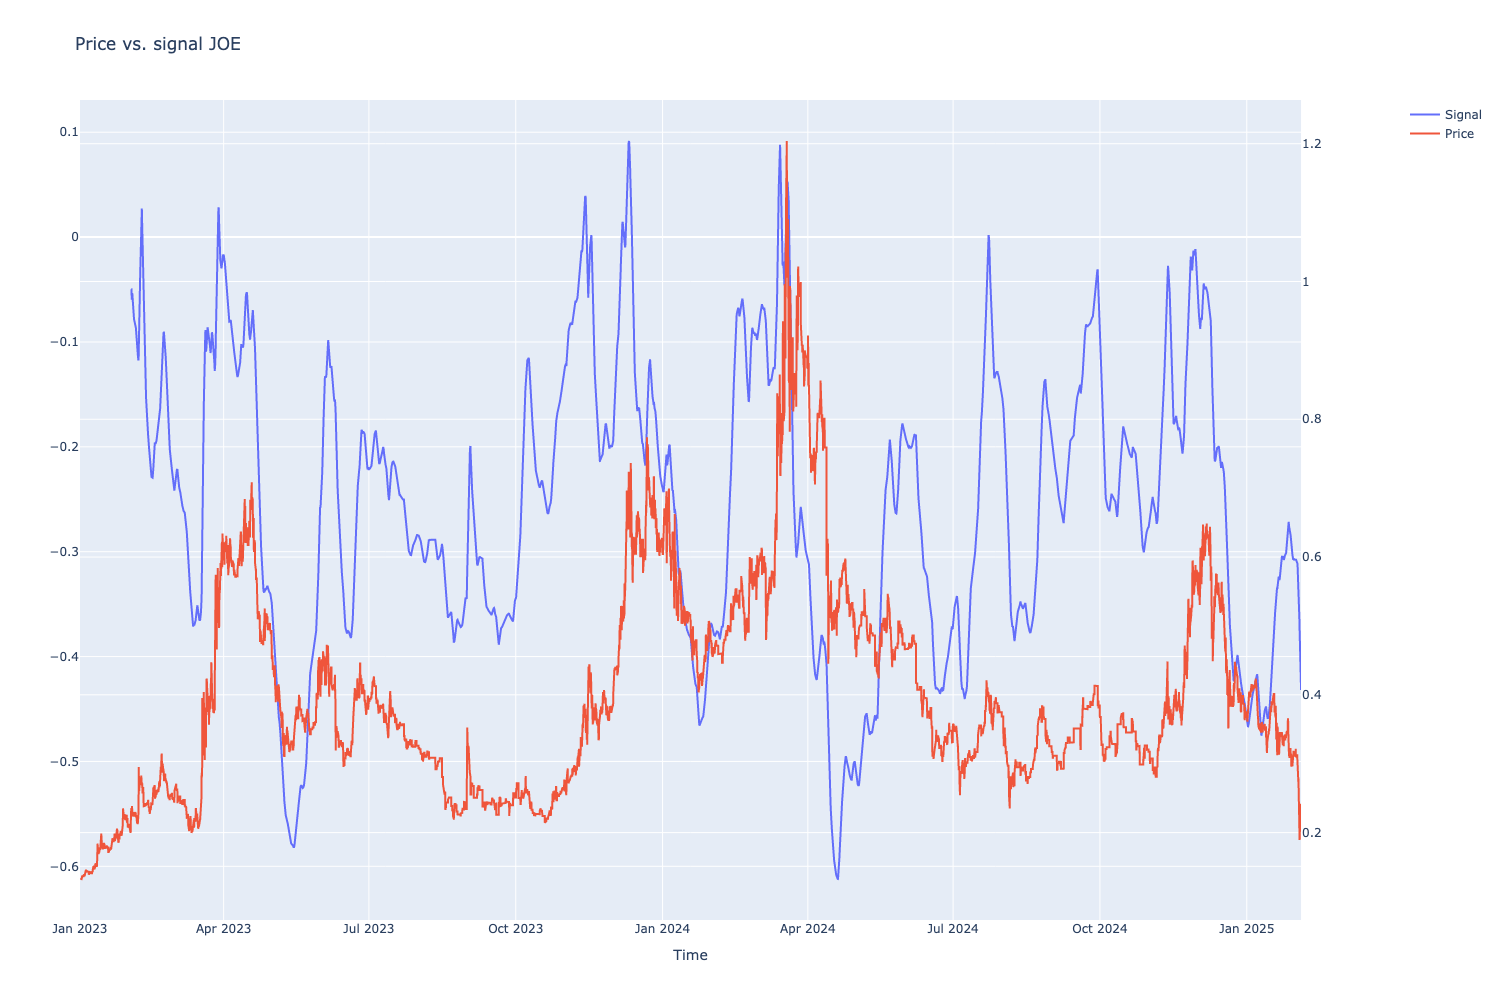

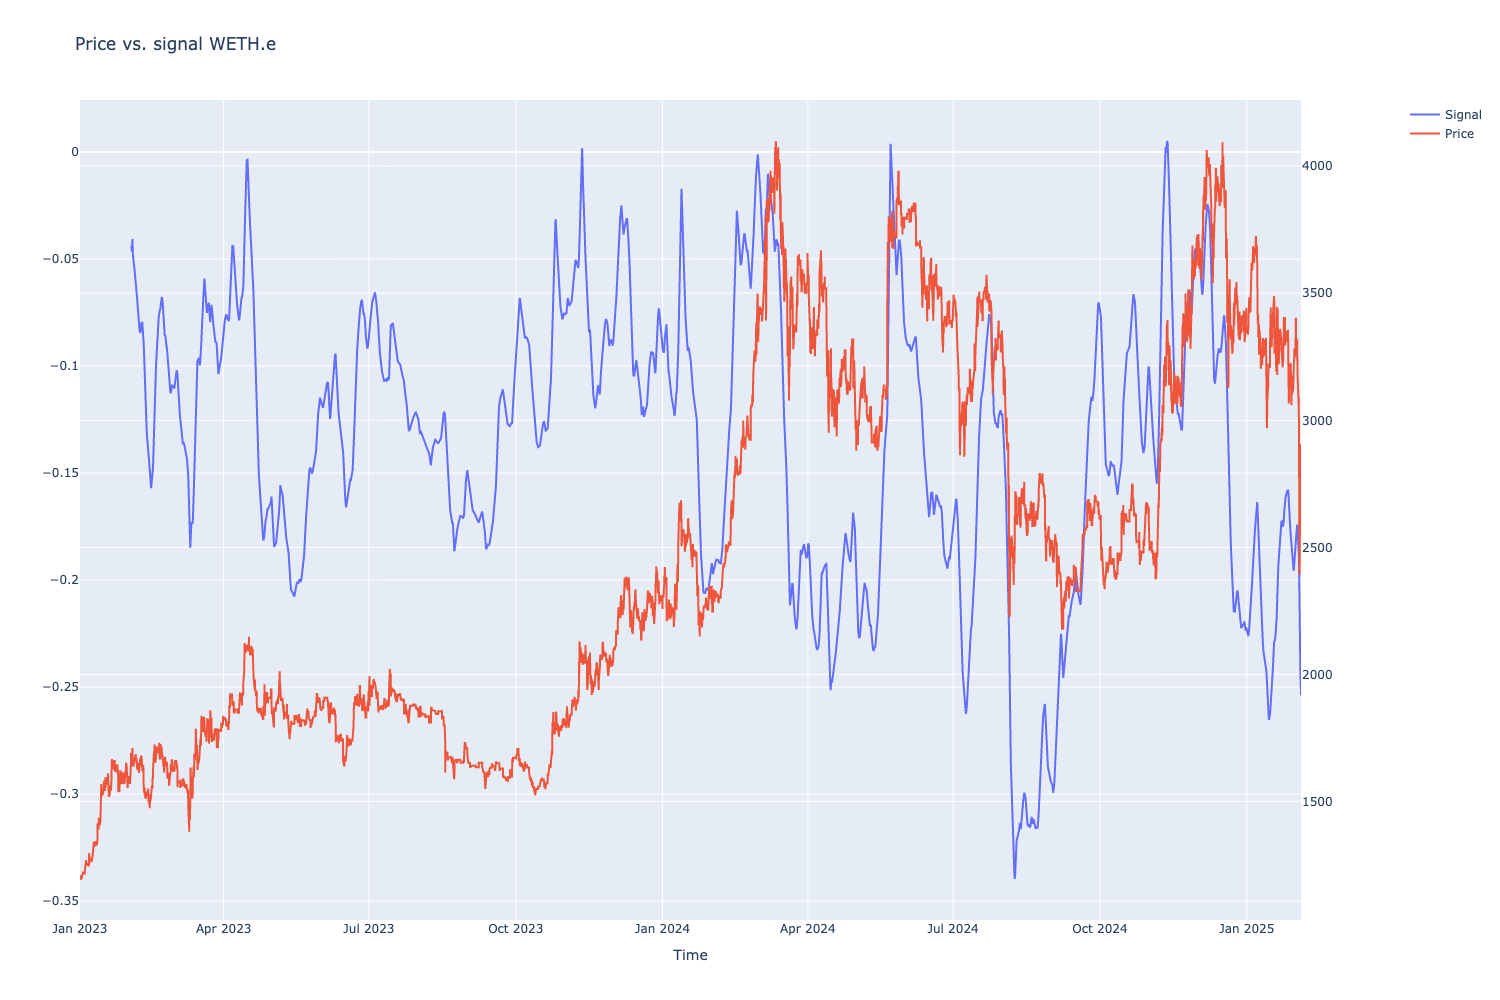

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("signal", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        # "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Signal"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. ATH indicator

- Plot ATH indicator

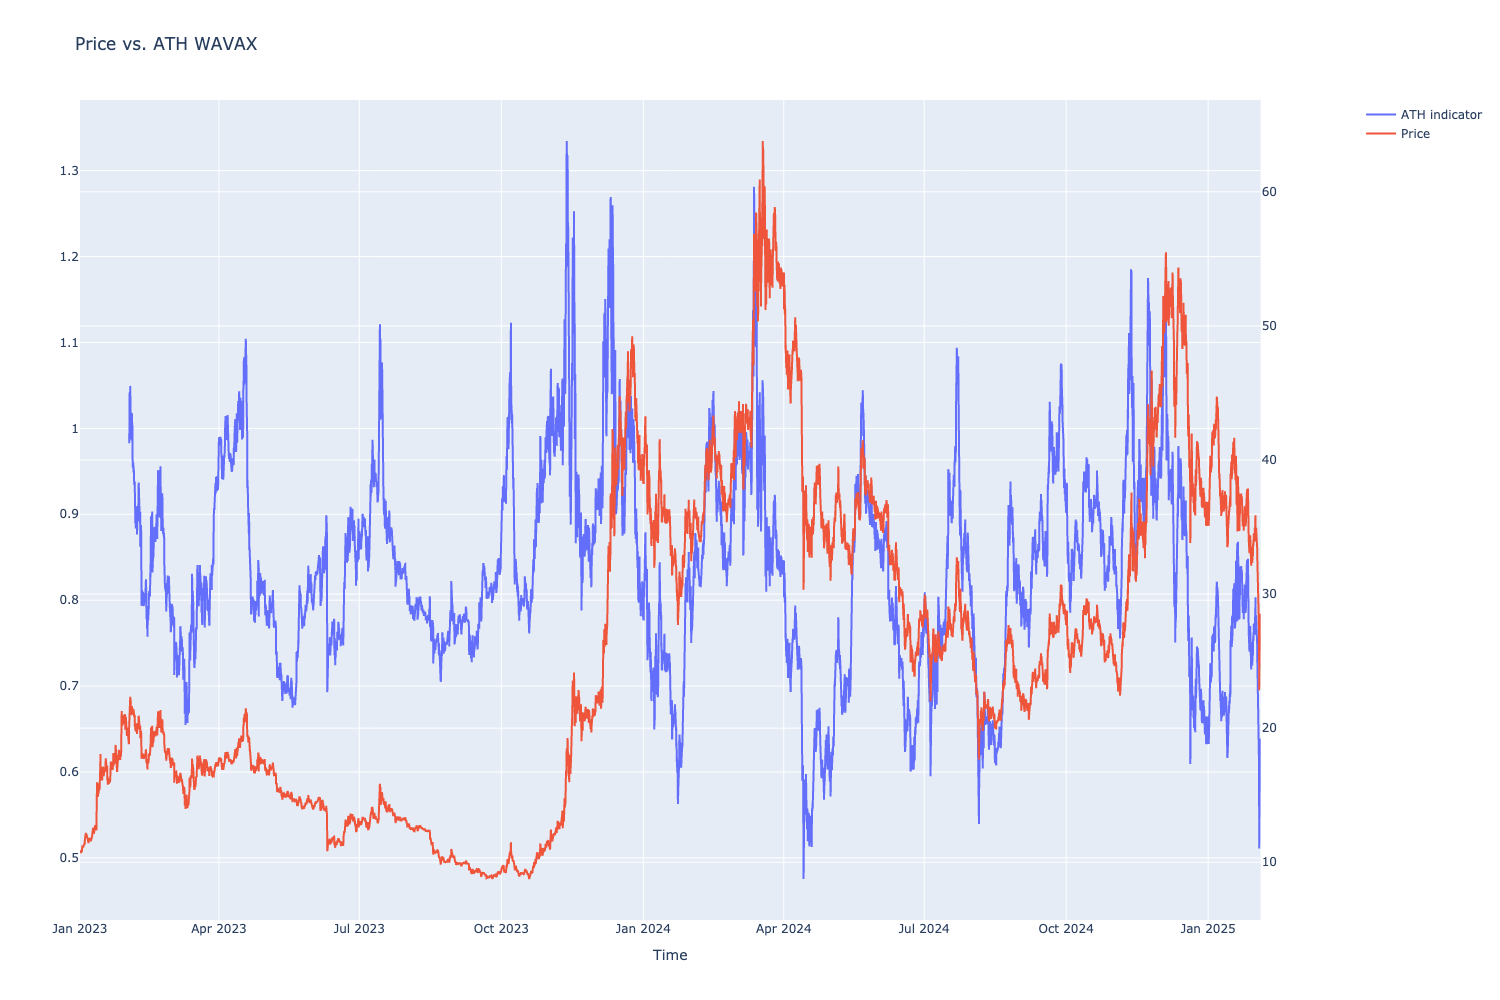

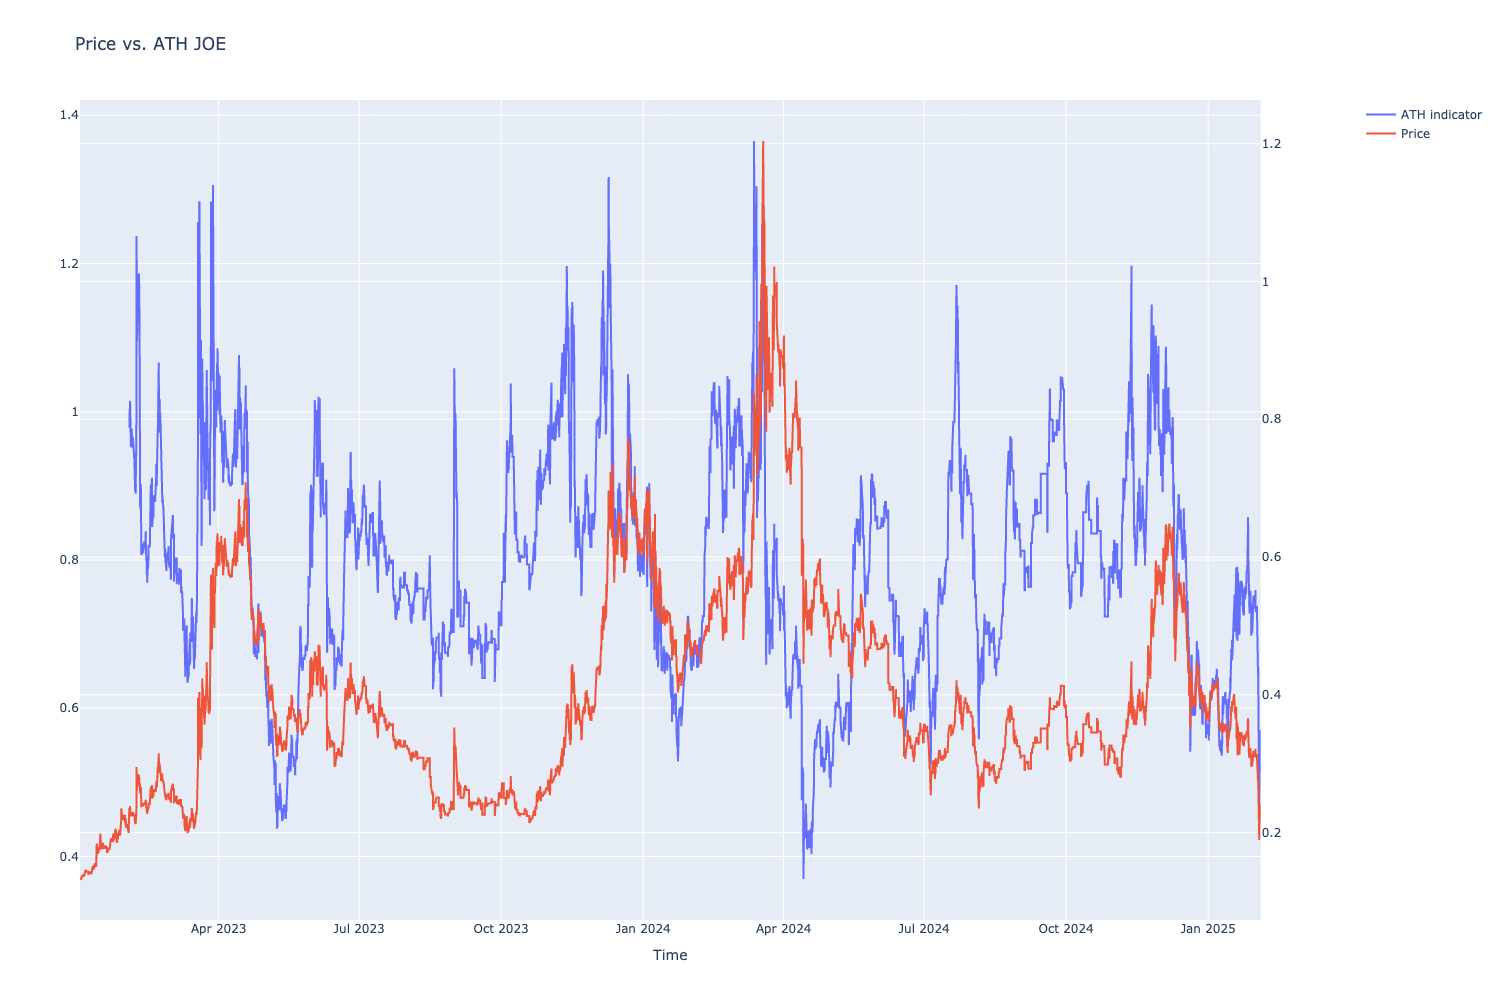

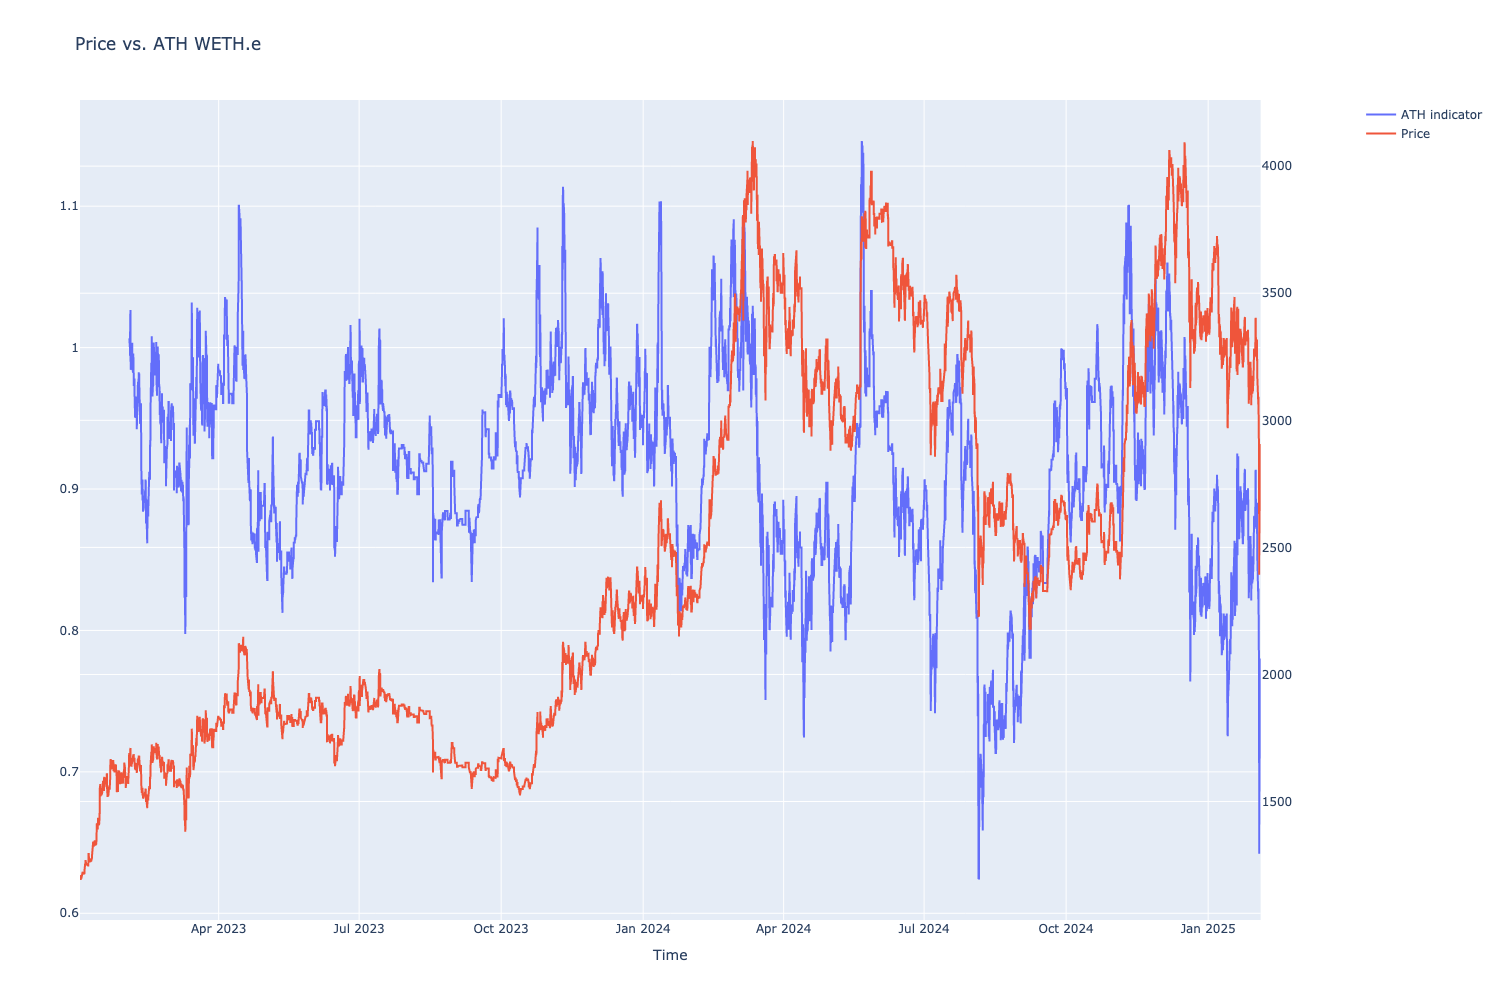

In [41]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("ath", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="ATH indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. ATH {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. daily RSI

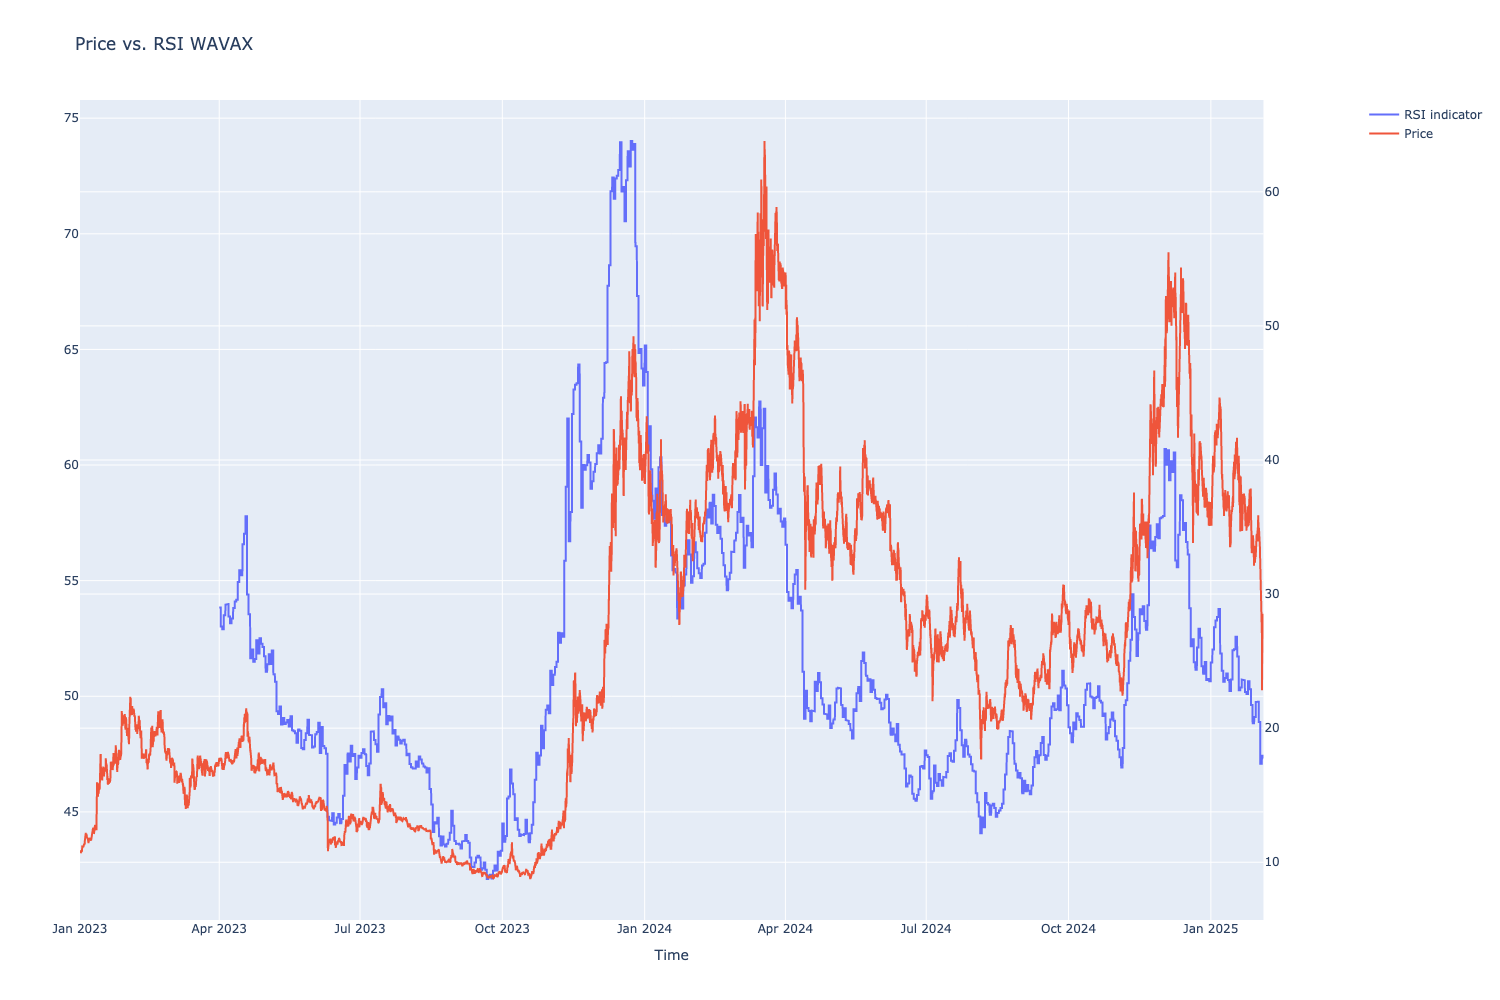

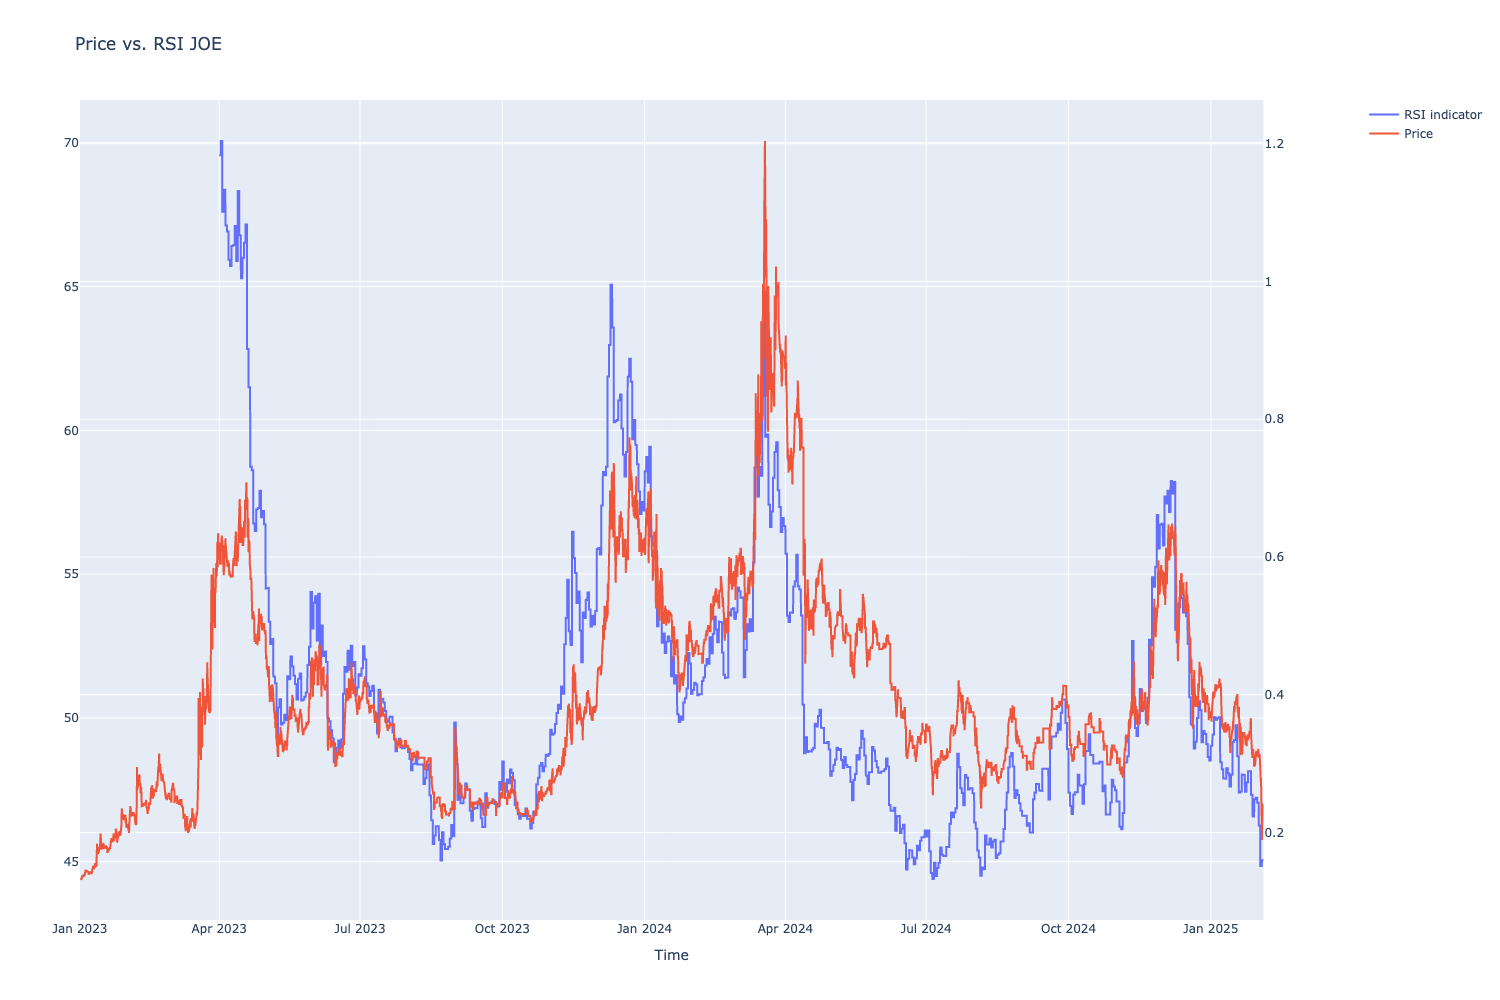

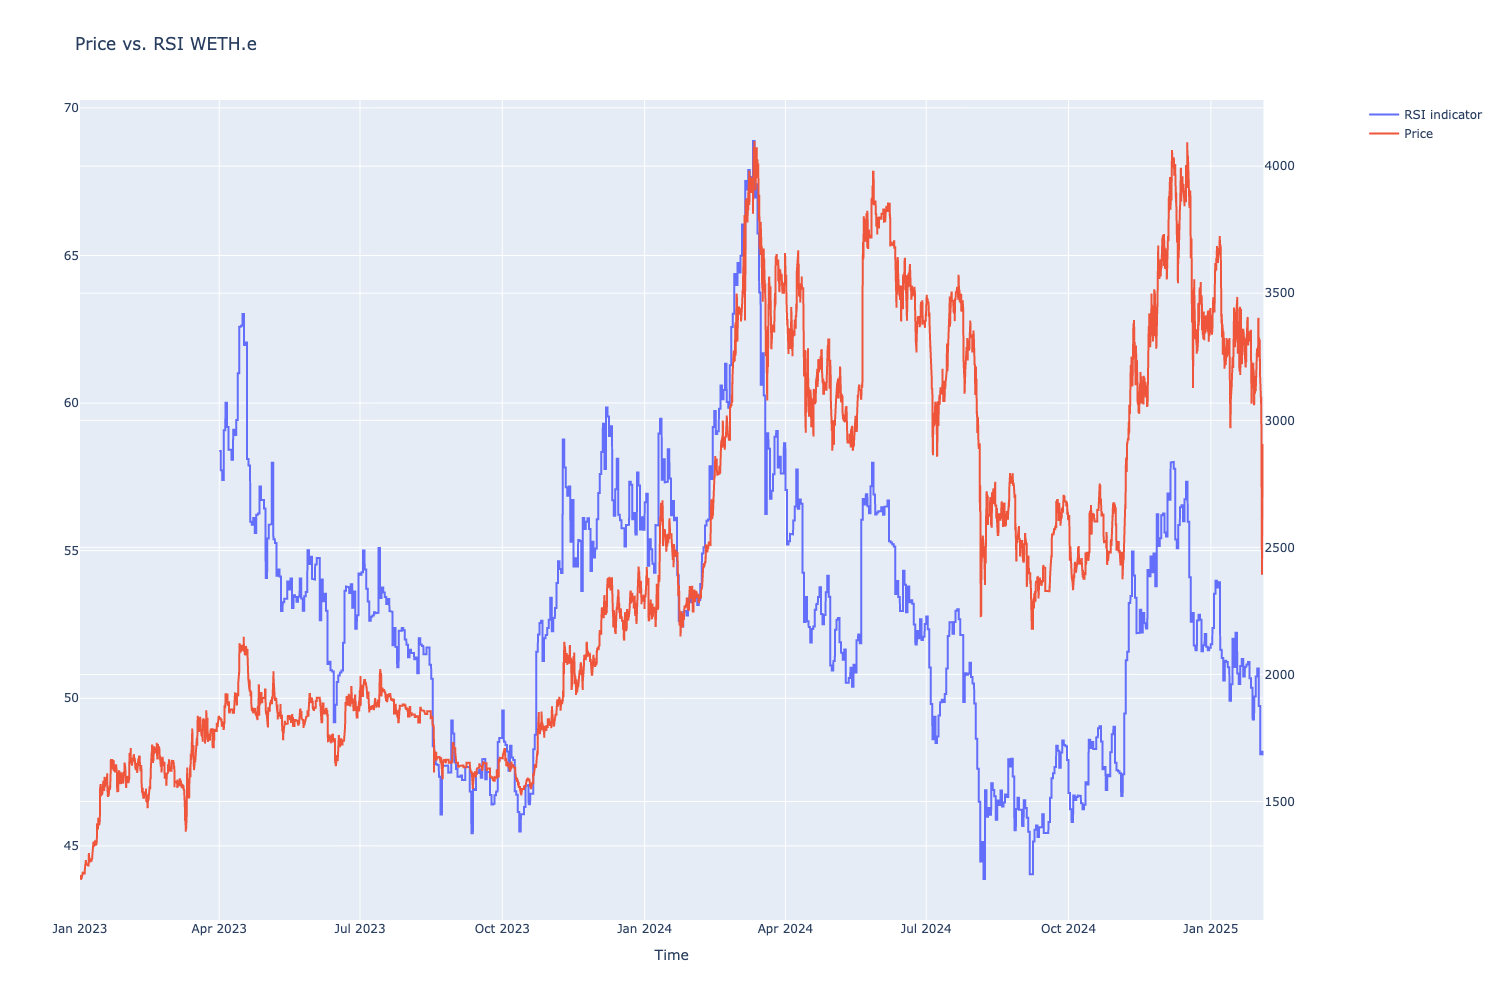

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("daily_rsi", pair=pair)    

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
    })

    df["signal"] = df["signal"].ffill()

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="RSI indicator"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. RSI {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [43]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-01-01 00:00:00 - 2025-02-04 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [44]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []
    
    # Set signal for each pair
    signal_count = 0  
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal 

        if weight < 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Supply or withdraw cash to Aave if strategy is set to do so
    if parameters.use_aave:
        credit_deposit_flow = position_manager.calculate_credit_flow_needed(
            trades,
            parameters.allocation,
        )
        credit_flow_dust_threshold = 3.0  # Min deposit USD to Aave
        if credit_deposit_flow > credit_flow_dust_threshold:
            trades += position_manager.manage_credit_flow(credit_deposit_flow)
    else:
        credit_deposit_flow = 0

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Credit deposit flow: {credit_deposit_flow:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)
    
    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators ath, volatility, rolling_cumulative_volume, rolling_liquidity_avg, volume_inclusion_…

Using indicator cache /Users/moo/.cache/indicators/avalanche_1h_97_2023-01-02-2025-02-04_ff


  0%|          | 0/66096000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 1780 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [45]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=EXAMINED_ASSETS,
    asset_count=6,
)

Strategy                 AVAX  \
Start Period                        2023-01-01           2023-01-01   
End Period                          2025-02-03           2025-02-03   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           88.0%                96.0%   
Cumulative Return                       100.6%               37.05%   
CAGR﹪                                   25.81%               10.96%   
Sharpe                                    1.49                 0.61   
Prob. Sharpe Ratio                      99.61%               81.25%   
Smart Sharpe                              1.34                 0.55   
Sortino                                   3.46                 0.94   
Smart Sortino                             3.11                 0.85   
Sortino/√2                                2.45                 0.67   
Smart Sortino/√2                           2.2                  0.6   
Omega                                     1.86                 1.86   
Max Drawdown                           -17.67%               -67.1%   
Longest DD Days                            325                  321   
Volatility (ann.)                       24.12%               89.12%   
Calmar                                    1.46                 0.16   
Skew                                      5.37                 0.53   
Kurtosis                                 53.37                  2.7   
Expected Daily                           0.09%                0.04%   
Expected Monthly                         2.71%                1.22%   
Expected Yearly                         26.12%               11.08%   
Kelly Criterion                         20.64%                6.85%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -1.98%               -7.52%   
Expected Shortfall (cVaR)               -1.98%               -7.52%   
Max Consecutive Wins                        13                    8   
Max Consecutive Losses                       9                    9   
Gain/Pain Ratio                           0.86                 0.09   
Gain/Pain (1M)                            5.32                 0.59   
Payoff Ratio                              2.29                 1.21   
Profit Factor                             1.86                 1.09   
Common Sense Ratio                        3.44                 1.35   
CPC Index                                 1.91                 0.65   
Tail Ratio                                1.85                 1.23   
Outlier Win Ratio                        13.91                 2.98   
Outlier Loss Ratio                       14.94                 2.24   
MTD                                       0.0%               -21.4%   
3M                                        5.0%                8.64%   
6M                                       4.72%                5.15%   
YTD                                     -0.06%              -24.13%   
1Y                                      43.11%              -21.08%   
3Y (ann.)                               25.81%               10.96%   
5Y (ann.)                               25.81%               10.96%   
10Y (ann.)                              25.81%               10.96%   
All-time (ann.)                         25.81%               10.96%   
Best Day                                15.83%               22.92%   
Worst Day                               -4.82%              -16.78%   
Best Month                              36.45%               85.78%   
Worst Month                             -4.94%              -33.04%   
Best Year                               43.17%               99.58%   
Worst Year                              -0.06%              -24.13%   
Avg. Drawdown                           -4.16%               -22.8%   
Avg. Drawdown Days                          50                   80   
Recovery Factor                           4.27                

# Equity curve

- Equity curve shows how your strategy accrues value over time

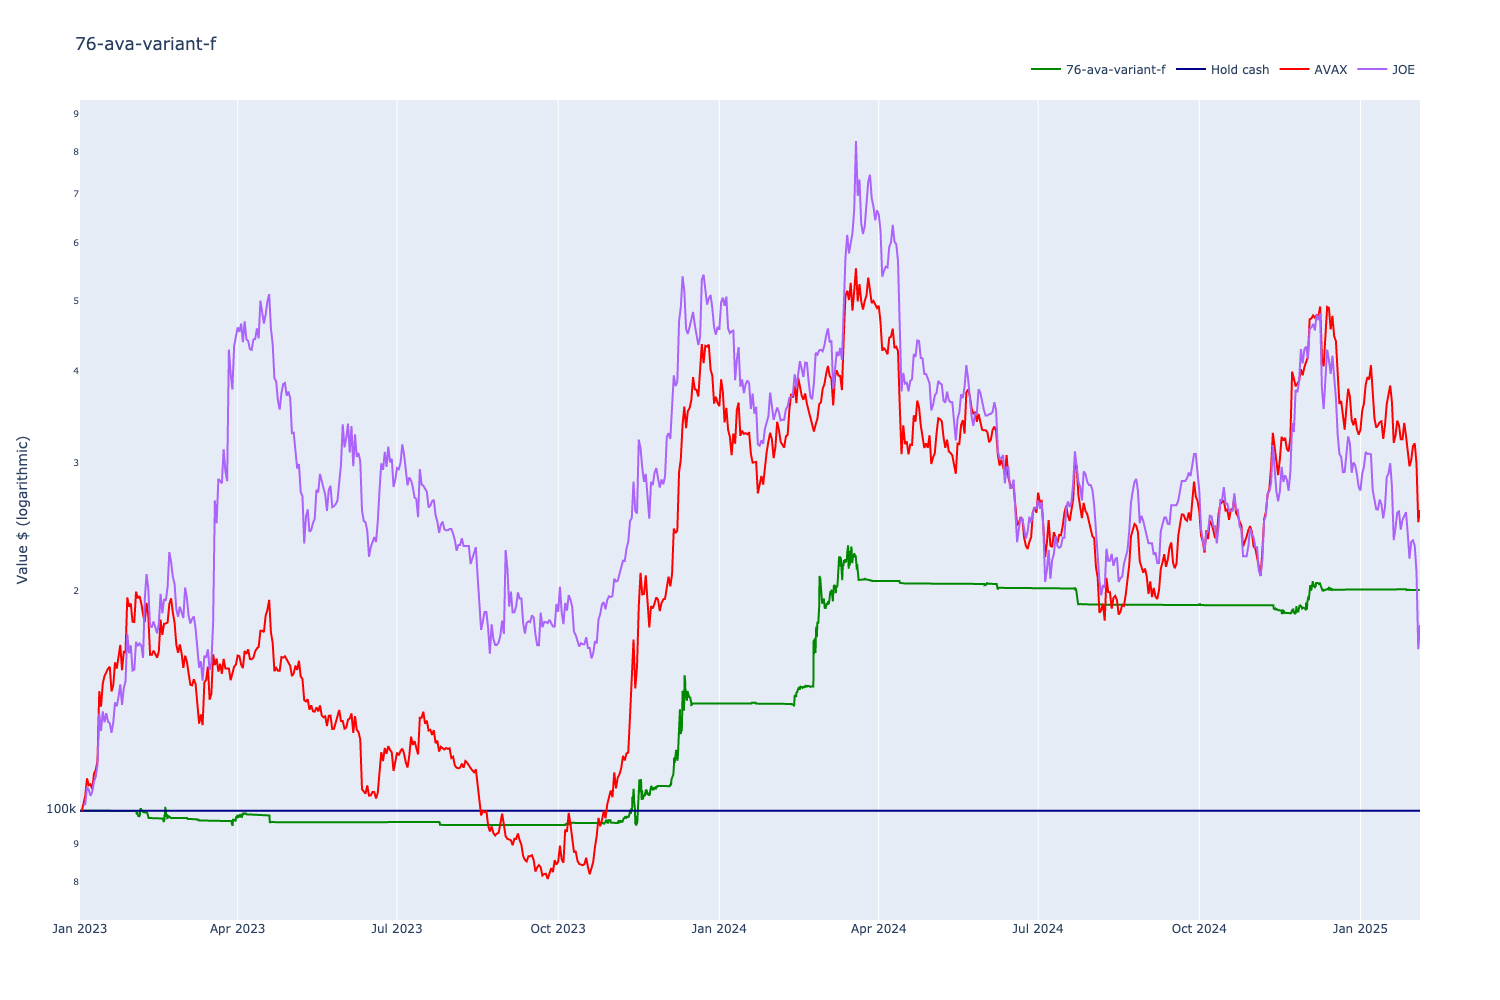

In [46]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WAVAX", "JOE"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

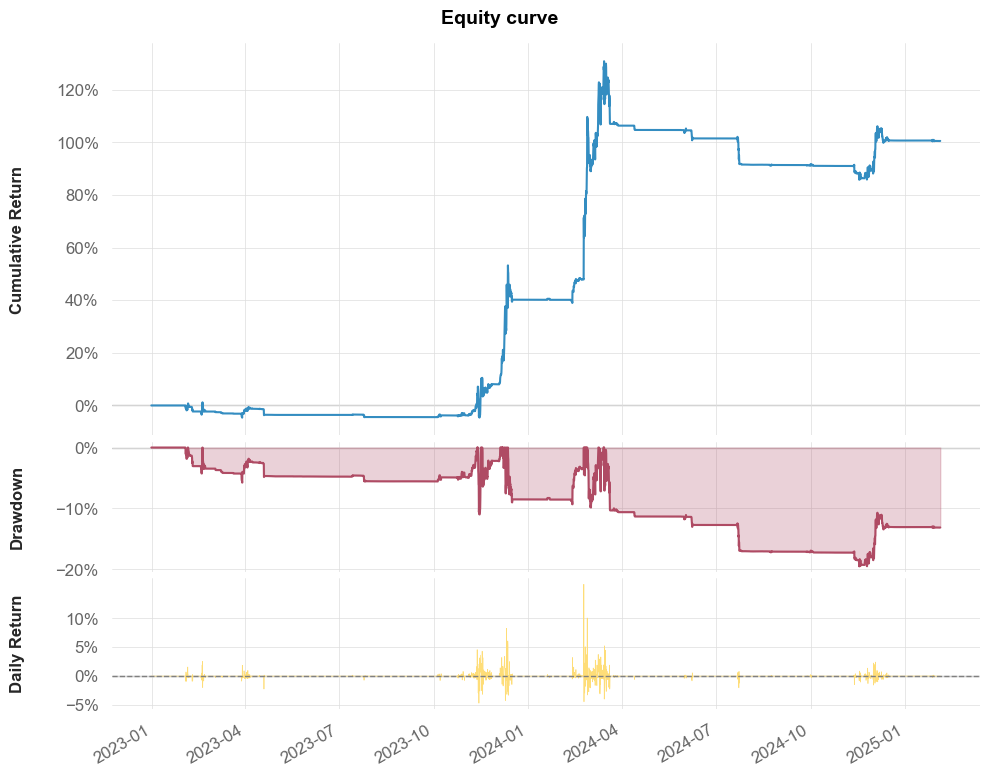

In [47]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

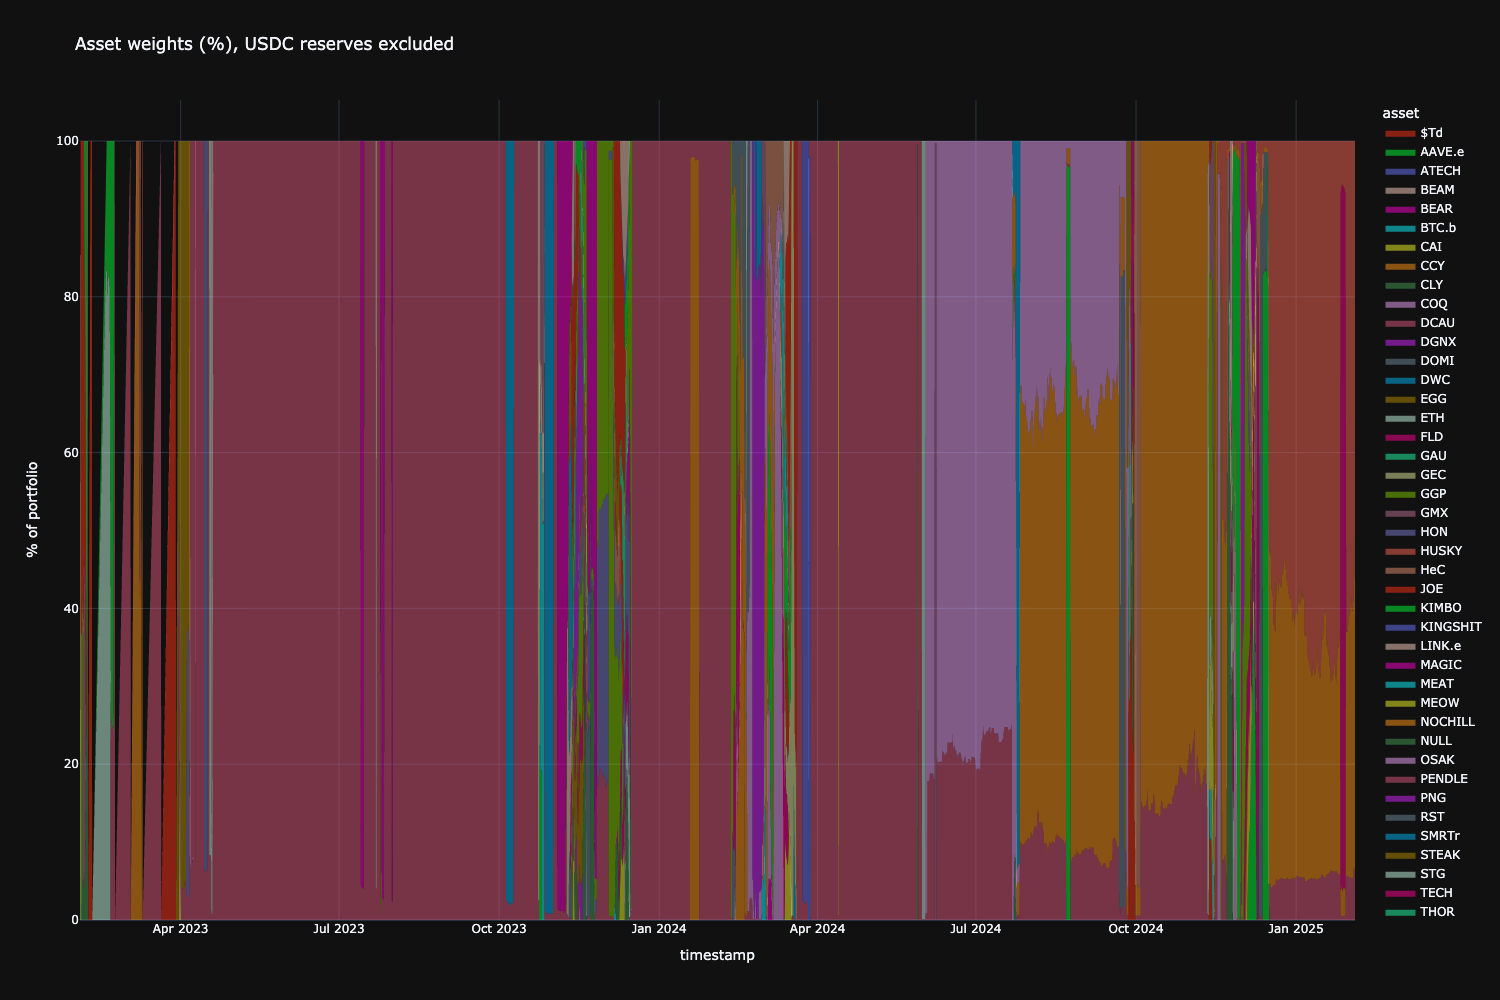

In [48]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

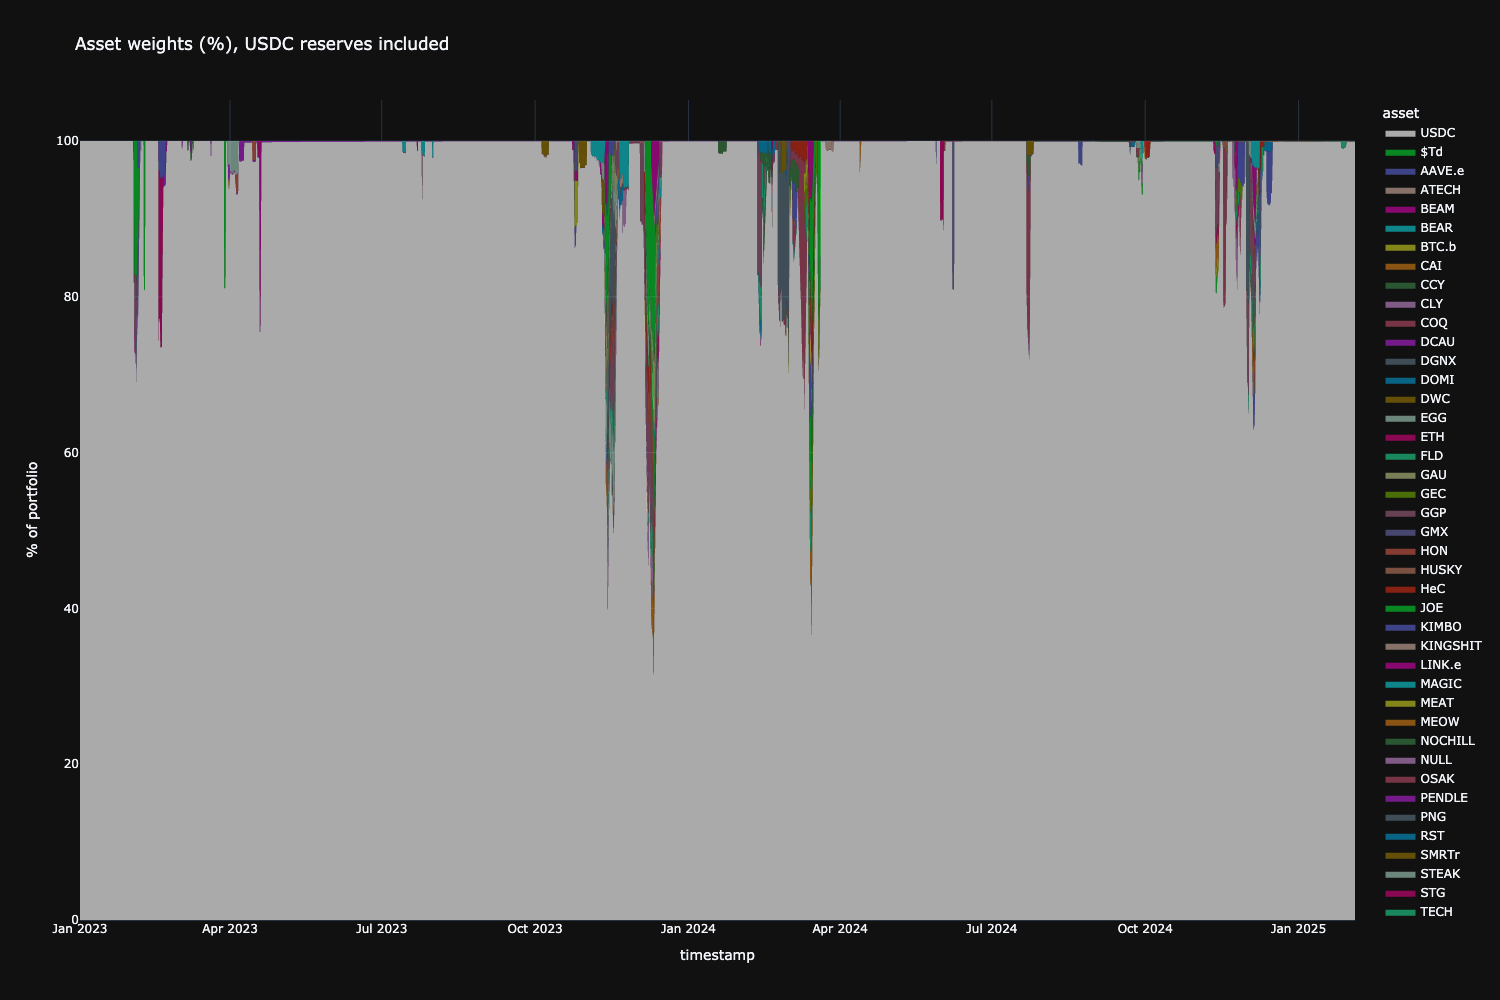

In [49]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

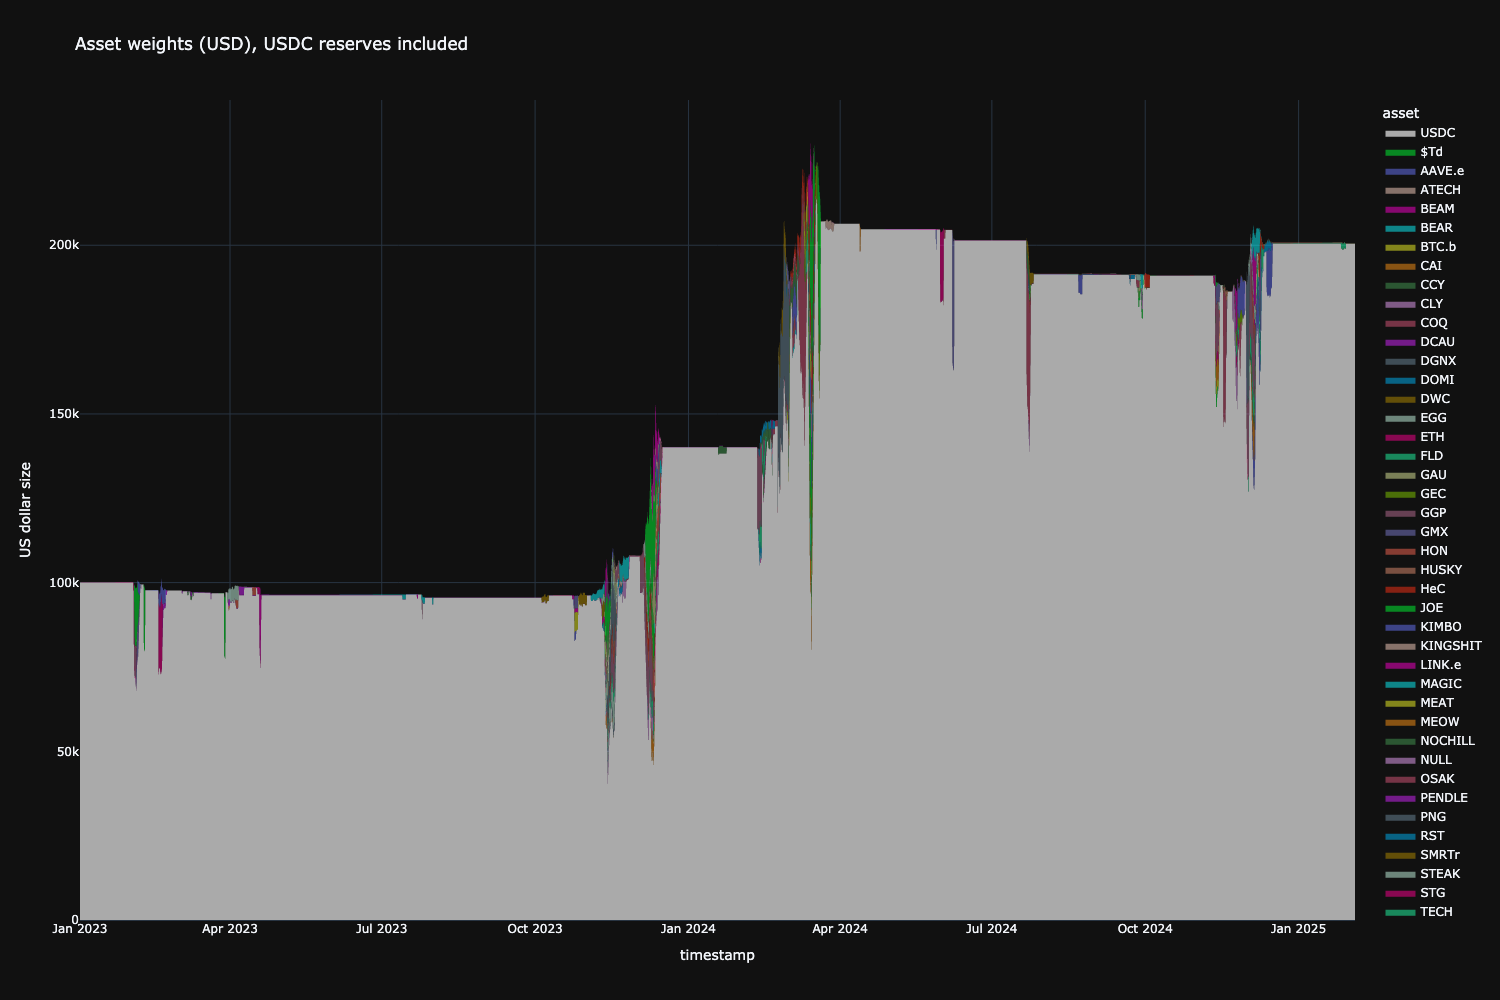

In [50]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [51]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At  Pair      Value Unit
Name                                                                     
Max position (excluding USDC)   2024-03-09 20:00:00   COQ  58,998.06  USD
Min position (excluding USDC)   2025-02-03 04:00:00  DCAU       8.49  USD
Mean position (excluding USDC)                              2,299.54  USD
Max position (excluding USDC)   2023-02-02 04:00:00   STG     100.00    %
Min position (excluding USDC)   2024-12-05 00:00:00  DCAU       0.02    %
Mean position (excluding USDC)                                 41.23    %
Max position (including USDC)   2023-01-01 00:00:00  USDC     100.00    %
Min position (including USDC)   2025-02-03 12:00:00  DCAU       0.00    %
Mean position (including USDC)                                 31.32    %

# Positions at the end

Some example positions at the end


In [52]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position DCAU, value 8.696309281212947 USD
Position NOCHILL, value 82.87689748320095 USD
Position WET, value 82.0189287892623 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [53]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [54]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Empty DataFrame
Columns: []
Index: []

# Trading pair breakdown

- Trade success for each trading pair



In [55]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [56]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Examine single pair

- Show trades taken against a single pair

We have total 58 trades on <Pair JOE-WAVAX spot_market_hold at 0x454e67025631c065d3cfad6d71e6892f74487a15 (0.3000% fee) on exchange trader-joe>


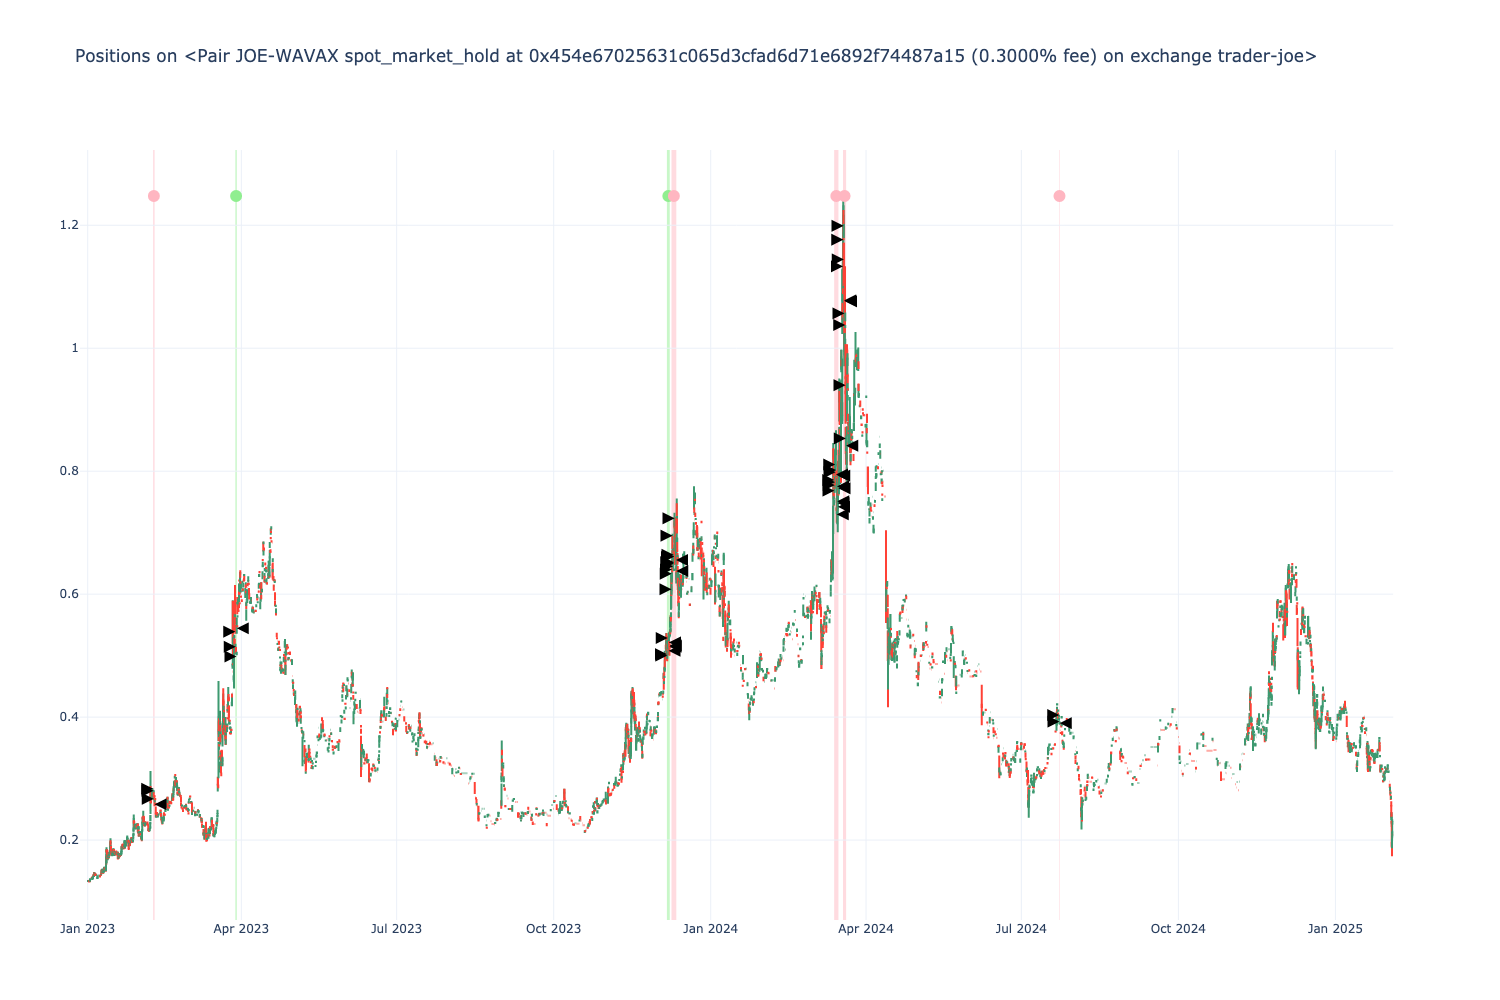

In [59]:
from tradeexecutor.visual.single_pair import visualise_single_pair_positions_with_duration_and_slippage

pair = token_map["JOE"]  # Get previously resolved trading pair

all_trades = [t for t in state.portfolio.get_all_trades() if t.pair == pair]
print(f"We have total {len(all_trades)} trades on {pair}")

# start = datetime.datetime(2023, 2, 1)
# end = datetime.datetime(2023, 4, 1)

start = None
end = None

signal = indicator_data.get_indicator_series("signal", pair=pair)

figure = visualise_single_pair_positions_with_duration_and_slippage(
    state=state,
    candles=strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id),
    pair_id=pair.internal_id,
    execution_context=notebook_execution_context,
    title=f"Positions on {pair}",
    start_at=start,
    end_at=end,
)


figure.show()

## Examine positions

In [58]:
from tradeexecutor.visual.single_pair import display_positions_table
display_positions_table(state, pair, sort_by="PnL USD", ascending=True)

Close        Duration     PnL %  \
Open                                                                
2023-11-11 20:00:00 2023-11-19 04:00:00 7 days 08:00:00  17.38146   

                         PnL USD  Trades  
Open                                      
2023-11-11 20:00:00  1883.701644      30